Michael Sam, Abigail Kinaro, Kimberly Llajaruna, Emilia Mazzolenis, Hope Neveux

# Table of Contents
- [Introduction](#Introduction)
- [EDA](#Exploratory-Data-Analysis)
- [Preprocessing + Pipeline](#Preprocessing)
- [Modeling](#Modeling)
    - [Baseline](##Baseline:-Simple-CNN)
    - [Improved](##Improved:-More-Complex-CNN)
    - [Experimental](##Experimental:-SOTA-TL-No-Tune)
- [Results](#Results)
- [209: False Negatives with GradCAM](#209B:-False-Negative-GradCAM-Study)
- [209: Improving ResNet](#209B:-Improving-the-ResNet-Model)
- [Remarks](#Remarks)
- [Future Work](#Future-Work)

# Introduction

*Problem Statement*

We hope to produce models that accurately identify malaria infection in human cells using computer vision to classify images as infected or clear. With this in mind, our question is: "How can machine learning algorithms be used to accurately identify malaria parasites in human cell images and classify them as infected or not to improve the efficiency and accuracy of malaria diagnosis?" 

*Motivation & Context*

By creating a model that accurately and efficitenly does this, we hope to assist in improving quality of life and providing quick solutions for medical practictioners to accurately classify if human blood cells contain malaria. The Malaria Detection Project analyzes a dataset of cell images obtained from the NIH Website. The blood samples were collected from Chittagong Medical College Hospital in Bangladesh and subsequently photographed. By successfully creating this model, we are confident that we will be able to extract valuable insights from the data and contribute to the understanding of Malaria diagnosis and treatment.


*Data Description & Handling*

Our data is distributed via Kaggle (https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria) and originally sourced from NIH (https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-screener.html). The blood samples were collected from Chittagong Medical College Hospital in Bangladesh and subsequently photographed. There are 27,558 cell images collected among 193 total patients (148 infected, 45 uninfected), sorted into two directories: parasitized and clear, with RGB coding. Overalll, the data is relatively well-behaved as it shows no class imbalances, clear visual cues for infection, and a large dataset. Thus, we focused our EDA on image sizing since we suspected from the initial glance that padding might make some features harder to detect. From our training and test data, we noticed that images are somewhat square – images with higher widths are also taller. We noted some outliers, however, in width and height, which will be cared for using general resizing techniques.
 

*Technologies*

In this section, we will load required packages and read in the data. All networks are constructed or downloaded using Tensorflow: Keras. Metric plots are created using Matplotlib.pyplot, for which we often get accuracy and other common metrics from sklearn. Manipulated data is commonly stored in numpy arrays, for their ability to handle non-homogenous shapes.


## Packages

In [391]:
!pip install tf_keras_vis==0.8.4

Defaulting to user installation because normal site-packages is not writeable


In [392]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable


In [393]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


In [394]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2 
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, AveragePooling2D, GlobalAvgPool2D, Add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.applications.resnet_v2 import ResNet50V2
from tf_keras_vis.utils.scores import BinaryScore
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import random
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='TensorFlow Addons')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


In [395]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

AUTOTUNE = tf.data.AUTOTUNE

def set_seed(seed: int = 2266) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ["PYTHONHASHSEED"] = str(seed)

tensorflow version 2.12.0
keras version 2.12.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



## Loading the Data

In [396]:
# Opens the directory given the folder name (string)
# iterates over the files, gets the name, opens the image, encode it as pixel values (RGB, therefore tensor)
# adds pixel representation to the images array, which is returned for plotting using plt.imshow
def extract_images(folder_name):
    this_dir = os.fsencode(f"{folder_name}/")
    sizes = []
    images = []

    for img in os.listdir(this_dir):
        # Get the file name
        filename = os.fsdecode(img)
        # Open the file and get the width and height
        width, height = Image.open(f"{folder_name}/{filename}").size
        # Save the size as a tuple
        sizes.append([width, height])
        # Save the encoded pixel image
        images.append(np.asarray(Image.open(f"{folder_name}/{filename}")))

    # Return the images (pixel encoded) and resolution (width, height)
    return images, sizes


In [397]:
# Get the sizes and images
inf_image, inf_size = extract_images('Parasitized')
clr_image, clr_size = extract_images('Uninfected')

# Checking how many images we have
print(f'Number of Infected Images: {len(inf_image)}\nNumber of Clear Images: {len(clr_image)}\nTotal Images: {len(inf_image) + len(clr_image)}')

Number of Infected Images: 13779
Number of Clear Images: 13779
Total Images: 27558


# Exploratory Data Analysis

The original dataset had images of different sizes. To account for this, we have padded the images to all have the same size, which resulted in an np.ndarray of shape (27558,32,32,3), as there are 27,558 images, a 32x32 pixel resolution, and three color channels (red, green, and blue). Furthermore, the dataset contains only the images for classification; no other variables were included. As such, the data is stored in arrays where every entry corresponds to a pixel and is of type numpy.unit8, representing an unassigned 8-bit integer that can only range from 0 to 255. 

The following histograms will show the previously mentioned variation in image sizes.

## Reading Image Shapes

In [398]:
combined_sizes = np.concatenate((inf_size, clr_size))
combined_images = inf_image + clr_image

# Determine the maximmum width and height
max_width, max_height = np.max(combined_sizes[:, 0]), np.max(combined_sizes[:, 1])
print(f'Max Width: {max_width}, Max Height: {max_height}')

Max Width: 394, Max Height: 385


## Plotting Image Shape Distribution

We decide to plot the distribution of height and width in order to understand our data.

### Helper Function

In [399]:
def plot_height_width_dist_per_class(width, height, class_name):

    fig, axs = plt.subplots(1, 2, figsize = (12, 5))

    axs[0].hist(width, bins = 20, edgecolor = 'navy', alpha = 0.5)
    axs[0].axvline(np.min(width), linestyle = 'dotted', color = 'red', linewidth = 1, label = f'Min = {np.min(width)}')
    axs[0].axvline(np.percentile(width, 25), linestyle = 'dotted', color = 'red', linewidth = 1, label = f'Q1 = {np.percentile(width,25)}')    
    axs[0].axvline(np.median(width), linestyle = 'dotted', color = 'black', linewidth = 1, label = f'Median = {np.median(width)}')
    axs[0].axvline(np.percentile(width, 75), linestyle = 'dotted', color = 'red', linewidth = 1, label = f'Q3 = {np.percentile(width,75)}')        
    axs[0].axvline(np.max(width), linestyle = 'dotted', color = 'red', linewidth = 1, label = f'Max = {np.max(width)}')

    axs[1].hist(height, bins = 20, edgecolor = 'navy', alpha = 0.5)
    axs[1].axvline(np.min(height), linestyle = 'dotted', color = 'red', linewidth = 1, label = f'Min = {np.min(height)}')
    axs[1].axvline(np.percentile(height, 25), linestyle = 'dotted', color = 'red', linewidth = 1, label = f'Q1 = {np.percentile(height,25)}')
    axs[1].axvline(np.median(height), linestyle = 'dotted', color = 'black', linewidth = 1, label = f'Median = {np.median(height)}')
    axs[1].axvline(np.percentile(height, 75), linestyle = 'dotted', color = 'red', linewidth = 1, label = f'Q3 = {np.percentile(height,75)}')    
    axs[1].axvline(np.max(height), linestyle = 'dotted', color = 'red', linewidth = 1, label = f'Max = {np.max(height)}')

    axs[0].set_xlabel(f'Pixel Width Varitations in {class_name}')
    axs[0].set_ylabel('Count')
    axs[1].set_xlabel(f'Pixel Height Variations in {class_name}')
    axs[1].set_ylabel('Count')
    axs[0].legend()
    axs[1].legend()

    plt.suptitle(f'Distribution of Pixel Sizing for {class_name}')
    plt.tight_layout()

### Histogram of Width and Height (Combined)

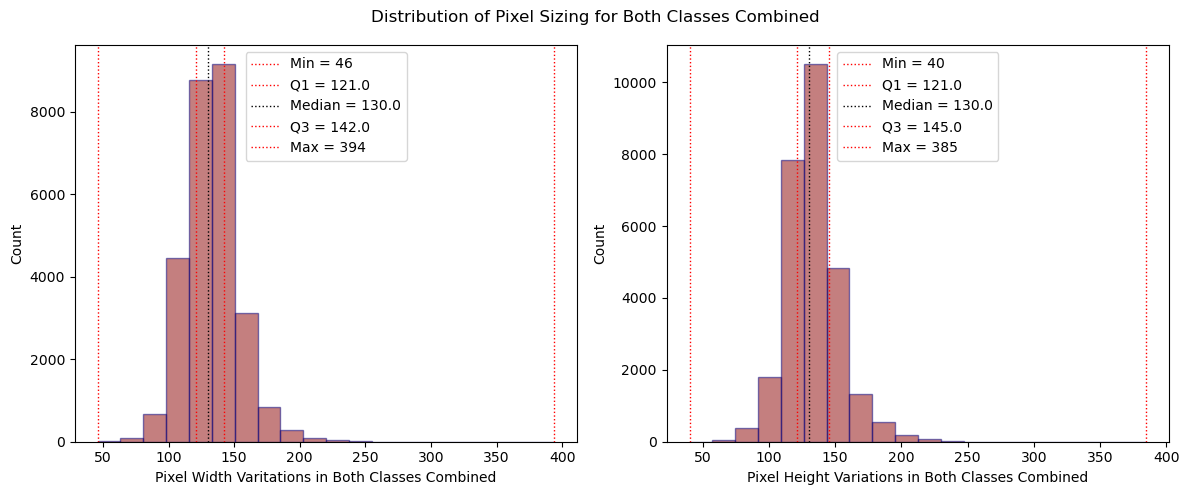

In [400]:
plot_height_width_dist_per_class(combined_sizes[:, 0],combined_sizes[:, 1], 'Both Classes Combined')

Above we see the distribution of pixel sizing for both classes combined. We can see that the width of the images ranged from 46 to 394 pixels, with a median value of 130 pixels, while the height ranged from 40 to 394 pixels, with a median value of 130 pixels.  


### Histogram of Width and Height (Infected)

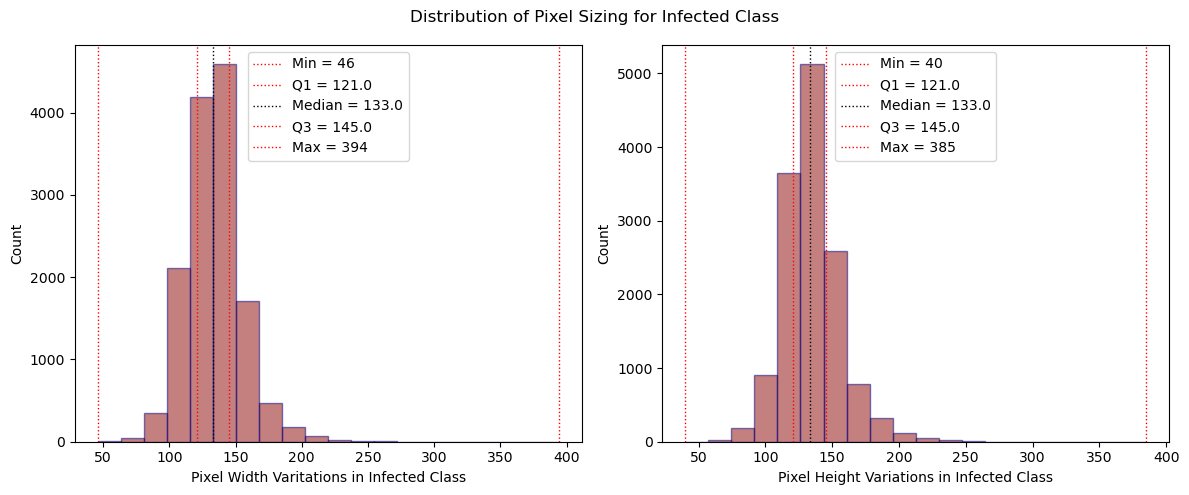

In [401]:
width_inf = [row[0] for row in inf_size]
height_inf = [row[1] for row in inf_size]

plot_height_width_dist_per_class(width_inf,height_inf, 'Infected Class')

Above we see the distribution of pixel sizing for the infected class. We can see that the width of the images ranged from 46 to 394 pixels, with a median value of 133 pixels, while the height ranged from 40 to 385 pixels, with a median value of 133 pixels.


### Histogram of Width and Height (Clear)

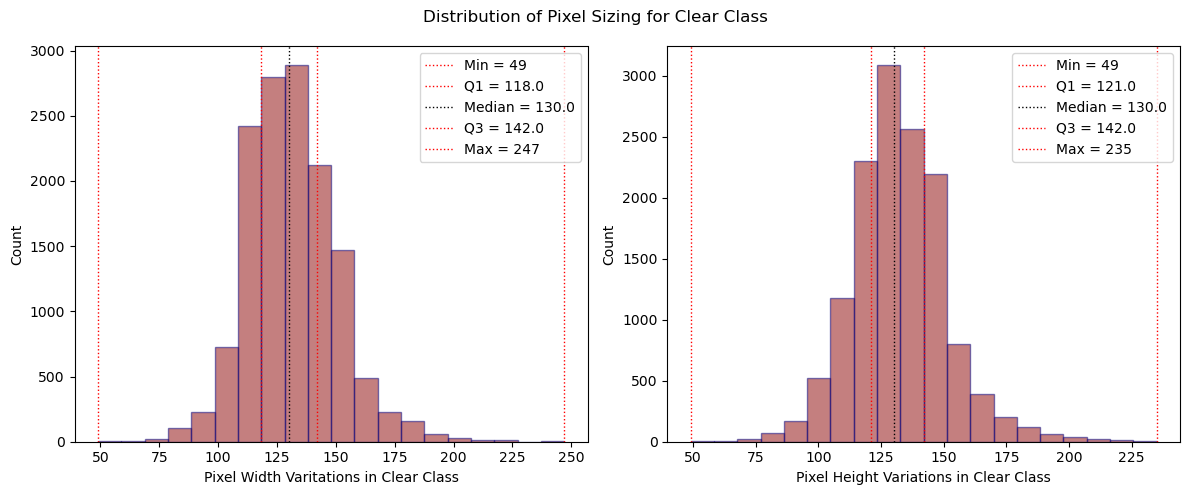

In [402]:
width_clr = [row[0] for row in clr_size]
height_clr = [row[1] for row in clr_size]
plot_height_width_dist_per_class(width_clr,height_clr, 'Clear Class')

Above we see the distribution of pixel sizing for the clear class. We can see that the width of the images ranged from 49 to 247 pixels, with a median value to 130 pixels, while the height ranged from 47 to 235, with a median value of 130 pixels. After comparing the distribution pixel sizing for both classes individually, we see more variation in sizing differences in the infected class.


### Scatterplot of Width and Height 

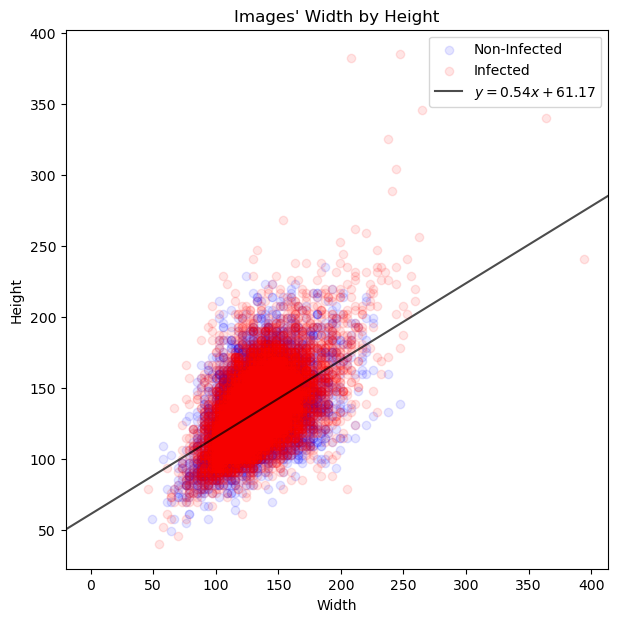

In [403]:
plt.subplots(1, 1, figsize = (7, 7))
plt.scatter(width_clr, height_clr, color='blue', marker='o', alpha = 0.1, label = 'Non-Infected')
plt.scatter(width_inf, height_inf, color='red', marker='o', alpha = 0.1, label = 'Infected')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title("Images' Width by Height")

m, b = np.polyfit(combined_sizes[:, 0], combined_sizes[:, 1], 1)
plt.axline(xy1=(0, b), slope=m, color='black', alpha=0.7, label=f'$y = {m:.2f}x {b:+.2f}$')
plt.legend();

Above we see a scatterplot of both clear and infected cell images width by height. We see a positive correlation between image width and height showing that images of greater width also have greater height. Hence, images are relatively square and can be resized.


### Boxplot of Width and Height

In [404]:
#  The images were concatenated in combined_sizes infected, clear, so we can split them up for better ideas
type_width = len(combined_sizes[:, 0]) * ['width']
type_height = len(combined_sizes[:, 1]) * ['height']
status_lab = np.concatenate((len(inf_image) * ['infected'], len(clr_image) * ['clear']))

In [405]:
initial_bx = pd.DataFrame(zip(combined_sizes[:, 0], type_width, status_lab), columns = ['size', 'type', 'status'])
initial_bx = pd.concat([initial_bx, pd.DataFrame(zip(combined_sizes[:, 1], type_height, status_lab), columns = ['size', 'type', 'status'])])

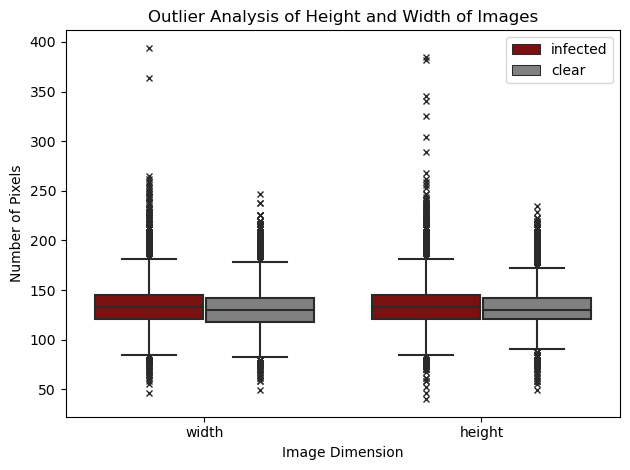

In [406]:
colors = ['darkred', 'grey']
sns.set_palette(sns.color_palette(colors))

sns.boxplot(data = initial_bx, y = 'size', x = 'type', hue = 'status', flierprops = {"marker": "x"})
plt.title('Outlier Analysis of Height and Width of Images')
plt.xlabel('Image Dimension')
plt.ylabel('Number of Pixels')
plt.legend()
plt.tight_layout()

Above we have boxplot visualizing the outlier analysis of the height and width of images. We see that the width and height distribution across types of cells are similar, but there being slightly more images of bigger infected cells.  There are some outliers, however this will be accounted for in the pre-processing steps when we resize the images.

## Understanding The Images

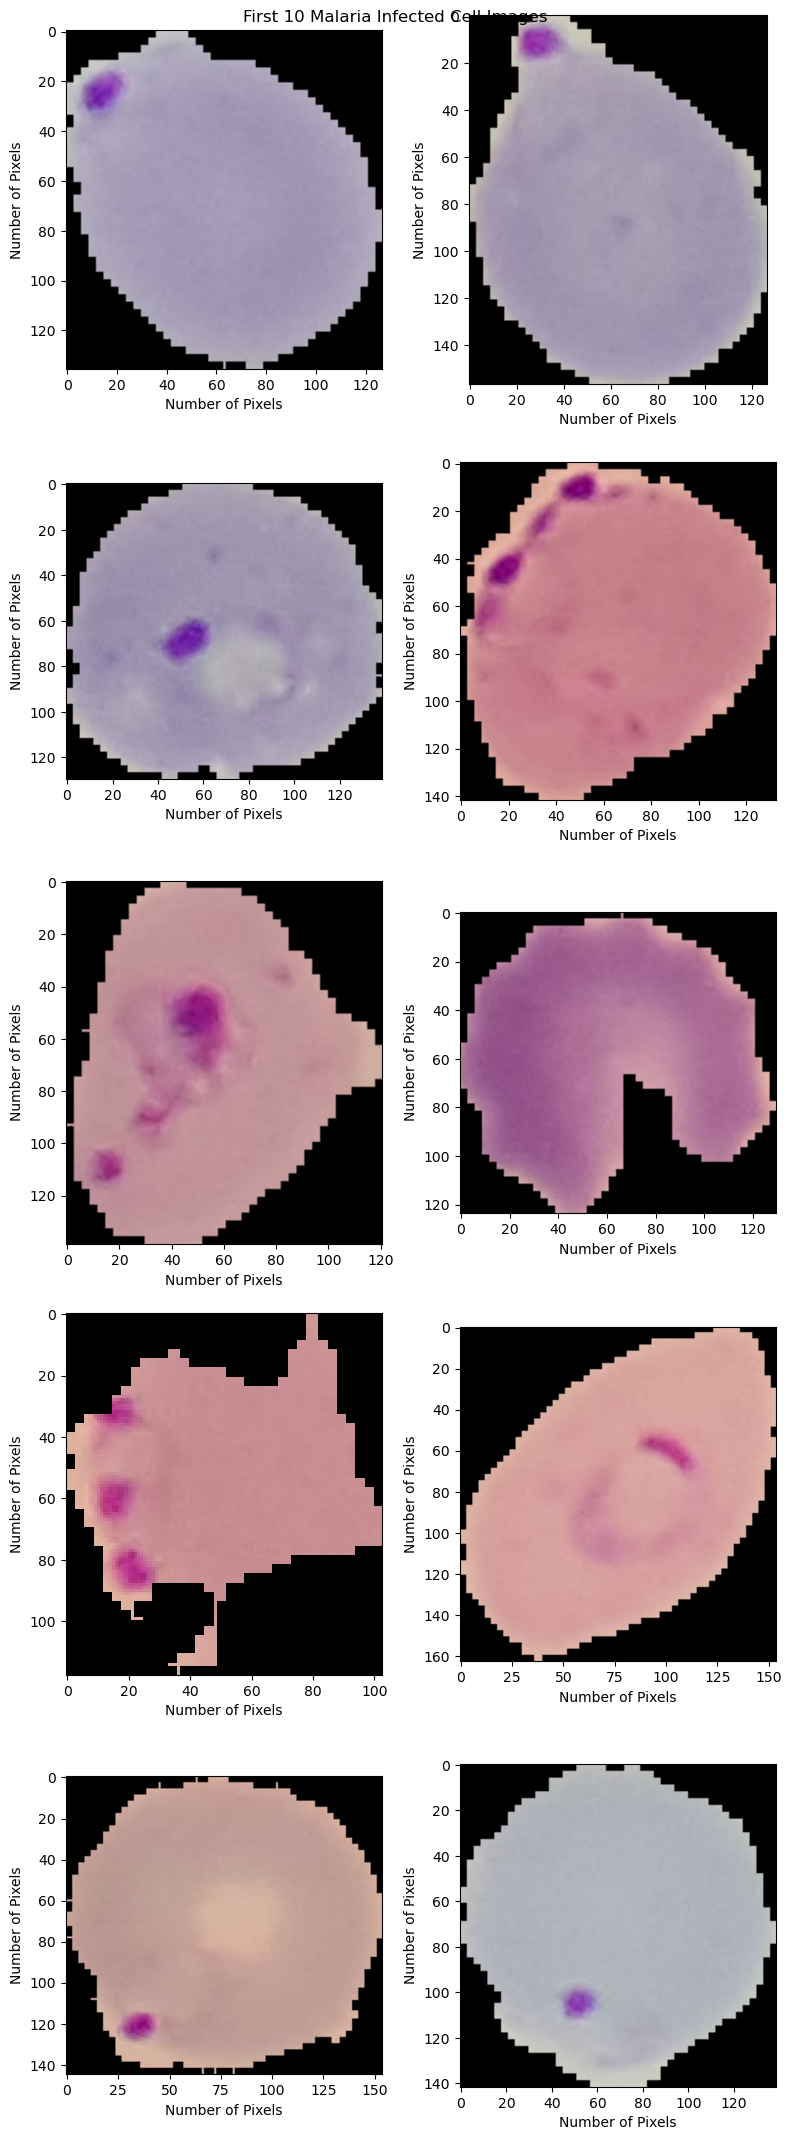

In [407]:
ncols, nrows = 2, 5
fig, axs = plt.subplots(nrows, ncols, figsize = (8, 22))

img_num = 0
for row in axs:
    for cell in row:
        cell.imshow(inf_image[img_num])
        cell.set_xlabel('Number of Pixels')
        cell.set_ylabel('Number of Pixels')
        img_num += 1

plt.suptitle('First 10 Malaria Infected Cell Images')
plt.tight_layout()

Above we see the first 10 cell images of infected cells.  

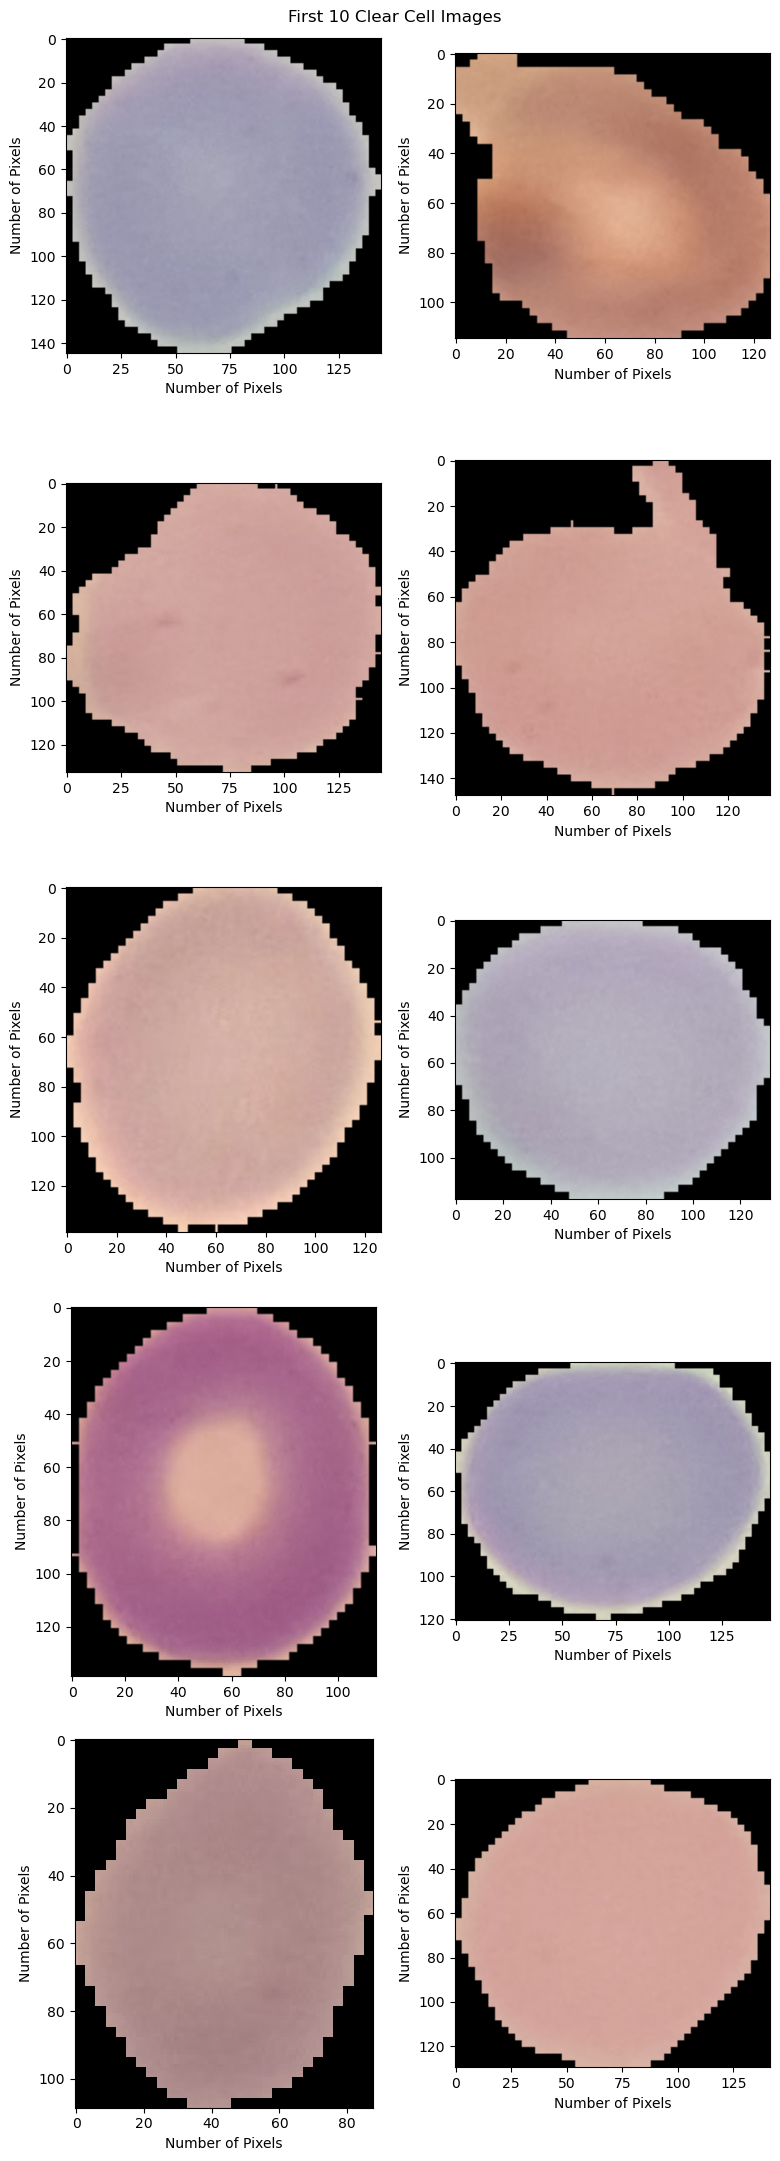

In [408]:
  # Same plotting setup
ncols, nrows = 2, 5
fig, axs = plt.subplots(nrows, ncols, figsize = (8, 22))

img_num = 0
for row in axs:
    for cell in row:
        cell.imshow(clr_image[img_num])
        cell.set_xlabel('Number of Pixels')
        cell.set_ylabel('Number of Pixels')
        img_num += 1

plt.suptitle('First 10 Clear Cell Images')
plt.tight_layout()

Above we see the first 10 images of clear cells. When comparing to those that are infected we note that the two have distinct visual cues distinguishing them from one another. Clear cells appear to be significantly more clearer versus their counterpart infected cells which show distinct pigmentation on in the cell images. We also note some infected cells have multiple regions of discoloration.

# Preprocessing

In order to use the images on our model, we need to resize, normalize and pad our data as follows: 

## Resizing and Normalization

In [409]:
def resize(image, size):
    resize_factor = max(image.shape[0]/size, image.shape[1]/size)
    d1 = int(image.shape[0]/resize_factor)
    d2 = int(image.shape[1]/resize_factor)
    final_size = [d1, d2]
    processed_img = tf.image.resize(image/255, final_size)
    return processed_img

## Padding

In [410]:
def pad(image, size):
    height_dif = size - image.shape[0]
    if height_dif % 2 == 0:
        pad_top = height_dif / 2
        pad_bottom = height_dif / 2
    else:
        pad_top = math.ceil(height_dif / 2)
        pad_bottom = math.floor(height_dif / 2)

    width_dif = size - image.shape[1]
    if width_dif % 2 == 0:
        pad_left = width_dif / 2
        pad_right = width_dif / 2
    else:
        pad_left = math.ceil(width_dif / 2)
        pad_right = math.floor(width_dif / 2)
    
    new_image = cv2.copyMakeBorder(image.numpy(), int(pad_top), int(pad_bottom), int(pad_left), int(pad_right), cv2.BORDER_CONSTANT, value=[0,0,0])
    return new_image

In [411]:
def preprocess(image, size):
    preprocessed_img = pad(resize(image,size),size)
    return preprocessed_img

## Basic Preprocessing (EDA Purposes Only)

In [412]:
size = 32

def final_size(size, clr_image, inf_image):
    clr_image_final = [preprocess(x,size) for x in clr_image]
    clr_image_final = np.stack(clr_image_final, axis=0)
    y_clr_image_final = np.zeros(clr_image_final.shape[0])

    inf_image_final = [preprocess(x,size) for x in inf_image]
    inf_image_final = np.stack(inf_image_final, axis=0)
    y_inf_image_final = np.ones(inf_image_final.shape[0])
    return clr_image_final, y_clr_image_final, inf_image_final, y_inf_image_final

clr_image_final, y_clr_image_final, inf_image_final, y_inf_image_final = final_size(32,clr_image,inf_image)

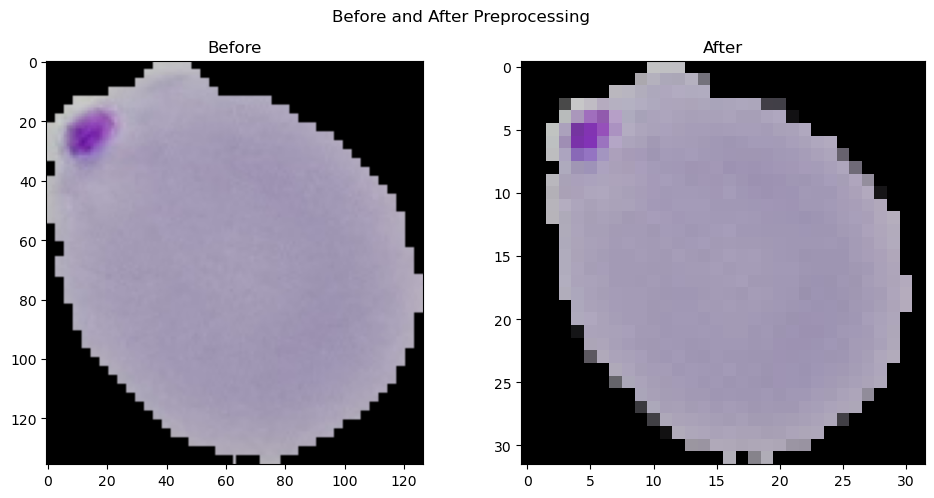

In [413]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(nrows, ncols, figsize = (10, 5))
axs[0].imshow(inf_image[0])
axs[0].set_title("Before")
axs[1].imshow(inf_image_final[0])
axs[1].set_title("After")
plt.suptitle('Before and After Preprocessing')
plt.tight_layout()

Above we see the before and after cell images of the pre-processing. In this step we resized all images to a fixed square size to ensure uniformity. First, we resized them such that the largest side had a size of our fixed value, and we also resized the other side, maintaining the width-height relationship of the original image. In the model above we used 32. Next, we normalized each image by dividing its values by 255. Finally, we padded it equally (top, bottom, right, and left) to achieve the desired square size. In this way, the image, after preprocessing, maximizes the original information, does not distort the width-height relationship, and is resized to a fixed square size.

Some noteworthy findings we found in the EDA process are:

- The size of the images is widely distributed. The new padding function allows to have all the images of the same size while keeping the cell area of a reasonable size for the model.

- Some images are pink-toned, while others are blue-toned. This may confuse CNN if there is an overwhelming amount of blue tones in either category in comparison

- After preprocessing, if we set a small final size (like 32x32x3), the images and features become blurry, but large malaria spots remain detectable. This may be an issue for the CNN when too-small infectious regions become too blurred. However, we can set a bigger final size so that we don’t lose much quality.Some images in the uninfected categories appear to have characteristics of the infected cells from visual inspection. Therefore, we will take the data as ground truth, but it might be helpful also to cluster the images without the labels and see if we can detect a “life-cycle” of malaria infection.

## Pipeline



We use a combination of up and down sampling by resizing images, then padding them as to not make any images too small (and therefore the features too insignificant) or too big (where we crop cells and lose infection data). To ensure we retain consistentcy, we build the dataset from the separated list of images (which currently have no explict labels) using 0 to indicate no infection and 1 to indicate infection. We then pass the full list of images stored in X to the `pipeline` function which calls other small helpers to resize and pad every image to shape (32, 32, 3). 

Then, we split into train and test sets 70%/30%, for which the models will internally take another 20% out of the training data for validation. Given our models are likely to become complex and we have over 27,000 images that may cause overfitting and long train time, we choose a batch size of approximately 10% of the total images.

In [414]:
# Starting with the original data and creating a common format that works with the universal pipeline
def join_ds(clr_imgset, inf_imgset):
    # Must use len over shape since they aren't np.arrays bc non-homogenous
    y = np.hstack((np.zeros(len(clr_imgset)), np.ones(len(inf_imgset)))).reshape(-1, 1)
    # make ragged (# images, 1)
    X = np.hstack((np.array(clr_imgset), np.array(inf_imgset))).reshape(-1, 1)

    return X, y

# Pipeline function, formerly prep_x, which hinges on the other preprocessing functions
def pipeline(X):
    # common size
    size = 32
    # force into array, even if it's a single image
    img_list = np.array(X)
    # padding, resizing all taken care of already
    imgs_prep = np.array([preprocess(img[0], size) for img in img_list])

    return imgs_prep

In [415]:
# Build dataset, then train and split
X, y = join_ds(clr_image, inf_image)

# Prep the data for training, testing, and general evaluation
X = pipeline(X)

# Split the prepped data into different sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

/tmp/ipykernel_66/4062602773.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.hstack((np.array(clr_imgset), np.array(inf_imgset))).reshape(-1, 1)


In [416]:
print(f'Train Set: {x_train.shape}, {y_train.shape}\n     Proportion Split: {np.mean(y_train)}')
print(f'Test Set: {x_test.shape}, {y_test.shape}\n     Proportion Split: {np.mean(y_test)}')

Train Set: (19290, 32, 32, 3), (19290, 1)
     Proportion Split: 0.49792638672887507
Test Set: (8268, 32, 32, 3), (8268, 1)
     Proportion Split: 0.5048379293662313


In [417]:
# Create tensorflow dataset
batch_size = round((len(inf_image) + len(clr_image)) * 0.1)
print(f'Batch Size: {batch_size}')

Batch Size: 2756


# Model

## Helper Functions

In [418]:
# Final container to hold all modeling results
results = []

# Get all the informaiton about the train and validation losses and metrics (always the same for these)
def save_results(model, model_name):
    train_acc = model.history.history["accuracy"]
    val_acc = model.history.history["val_accuracy"]

    train_loss = model.history.history["loss"]
    val_loss = model.history.history["val_loss"]

    # train accuracy
    train_accuracy = model.history.history["accuracy"][-1]
    # validation accuracy
    val_accuracy = model.history.history["val_accuracy"][-1]
    # test accuracy
    test_accuracy = model.evaluate(x_test, y_test)[1]
    
    # Add all accuracies to the overall results
    results.append({model_name: [train_accuracy, val_accuracy, test_accuracy]})

    # print results
    print(f"Train accuracy is {train_accuracy*100:.2f}%")
    print(f"Validation accuracy is {val_accuracy*100:.2f}%")
    print(f"Test accuracy is {test_accuracy*100:.2f}%")

    return train_acc, val_acc, train_loss, val_loss

# Create the graphs for each of the networks 
def plot_res(train_acc, val_acc, train_loss, val_loss, ticks):
    # Number of history entries same for all 4 and dictates how long it ran for
    epochs = len(train_acc)
    # [0, epochs), then get every 5th entry for the ticks; must start at 0 or by 5 doesn't work properly
    epochs_x, x_ticks = np.arange(0, epochs), np.arange(0, epochs + 1, ticks)

    # Create lists for easy use in the loop
    results = [[train_acc, val_acc], [train_loss, val_loss]]
    lab = ['Accuracy', 'Loss']

    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    for metric, ax in enumerate(axs):
        ax.plot(epochs_x, results[metric][0], label = "Train", marker = "o", markersize = 4, alpha = 0.7)
        ax.plot(epochs_x, results[metric][1], label = "Validation", marker = "o", markersize = 4, alpha = 0.7)
        ax.set_xlabel("Number of Epochs")
        ax.set_ylabel(lab[metric])
        ax.set_title(f"{lab[metric]} and Number of Epochs")
        ax.axhline(y = 0.70, linestyle = ":", color = "grey")
        ax.set_xticks(x_ticks)
        ax.legend()
    
    plt.tight_layout()


## Baseline: Simple CNN

In [419]:
img_shape = x_train[1].shape

def build_model(img_shape, conv_pool_layers, num_filters, kernel_size, padding, model_name):
    set_seed(4)
    inputs = Input(img_shape)
    x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, activation="relu")(inputs)
    x = MaxPooling2D((3,3))(x)
    
    conv_pool_layers = conv_pool_layers - 1
    for i in range(conv_pool_layers):
        x = Conv2D(num_filters, kernel_size=kernel_size, padding=padding, activation="relu")(x)
        x = MaxPooling2D((3,3))(x)
            
    x = Flatten()(x)
    x = Dense(8, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=outputs, name= model_name)

In [420]:
model1 = build_model(img_shape, conv_pool_layers=1, num_filters=8, kernel_size=3, padding="same", model_name = "Baseline_CNN")

model1.compile(optimizer=Adam(), 
               loss='binary_crossentropy', 
               metrics=["accuracy"])

model1.summary()

Model: "Baseline_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 10, 10, 8)        0         
 g2D)                                                            
                                                                 
 flatten_46 (Flatten)        (None, 800)               0         
                                                                 
 dense_92 (Dense)            (None, 8)                 6408      
                                                                 
 dense_93 (Dense)            (None, 1)                 9         
                                                      

In [421]:
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![My Image](base_flow.png)

In [422]:
%%time
model1.fit(x_train, y_train, epochs = 10, validation_split = 0.2, batch_size = batch_size, verbose = 0);

2023-05-08 18:54:04.399309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:54:04.399881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:54:05.943781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and sha

CPU times: user 3.62 s, sys: 367 ms, total: 3.99 s
Wall time: 4.03 s


In [423]:
model1.save("data/models/project/model1")

INFO:tensorflow:Assets written to: data/models/project/model1/assets


INFO:tensorflow:Assets written to: data/models/project/model1/assets


In [424]:
train_acc, val_acc, train_loss, val_loss = save_results(model1, 'Baseline CNN')

 80/259 [========>.....................] - ETA: 0s - loss: 0.6780 - accuracy: 0.5852

2023-05-08 18:54:09.640791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:54:09.641266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]


259/259 [==============================] - 1s 2ms/step - loss: 0.6779 - accuracy: 0.5908
Train accuracy is 58.65%
Validation accuracy is 59.10%
Test accuracy is 59.08%


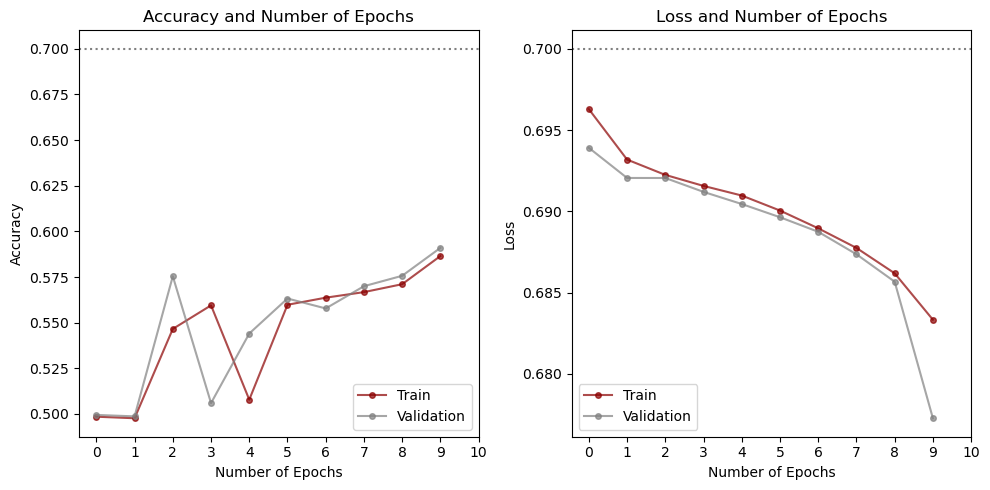

In [425]:
plot_res(train_acc, val_acc, train_loss, val_loss, ticks = 1)

For our baseline model, we did a basic CNN. We used the architecture: Input Layer, a Convolutional 2D Layer, one MaxPooling layer, one Flatten Layer, one Dense Layer, and the Output Layer. The total number of parameters in the model was 6,641 (all being trainable). We selected Adam with the optimizer's default setting, and we used binary cross entropy for the loss function.

In this, we got a training accuracy of 58.65%, a validation accuracy of 59.10%, and a test accuracy of 59.08%. Based on this, we see no overfitting in the model. In the plots above, we can see that the model is still monotonically decreasing in the loss and non-convergent. Thus, improvements of the baseline model will include training for more epochs. 

## Improved: More Complex CNN

In [426]:
model2 = build_model(img_shape, conv_pool_layers=2, num_filters=16, kernel_size=3, padding="same", model_name = "Complex_CNN")

model2.compile(optimizer=Adam(1e-2), 
               loss='binary_crossentropy', 
               metrics=["accuracy"])

model2.summary()

Model: "Complex_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 10, 10, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 3, 3, 16)         0         
 ng2D)                                                           
                                                                 
 flatten_47 (Flatten)        (None, 144)               

In [427]:
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![My Image](improved_flow.png)

In [428]:
%%time
model2.fit(x_train, y_train, epochs = 100, validation_split = 0.2, batch_size = batch_size, verbose = 0);

2023-05-08 18:54:11.453046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:54:11.453564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:54:13.363431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and sha

CPU times: user 23.7 s, sys: 4.08 s, total: 27.8 s
Wall time: 30.7 s


In [429]:
model2.save("data/models/project/model2")

INFO:tensorflow:Assets written to: data/models/project/model2/assets


INFO:tensorflow:Assets written to: data/models/project/model2/assets


In [430]:
train_acc, val_acc, train_loss, val_loss = save_results(model2, 'Complex CNN')

 79/259 [========>.....................] - ETA: 0s - loss: 0.1358 - accuracy: 0.9521

2023-05-08 18:54:42.935617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:54:42.935992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]


259/259 [==============================] - 1s 2ms/step - loss: 0.1590 - accuracy: 0.9456
Train accuracy is 95.70%
Validation accuracy is 94.50%
Test accuracy is 94.56%


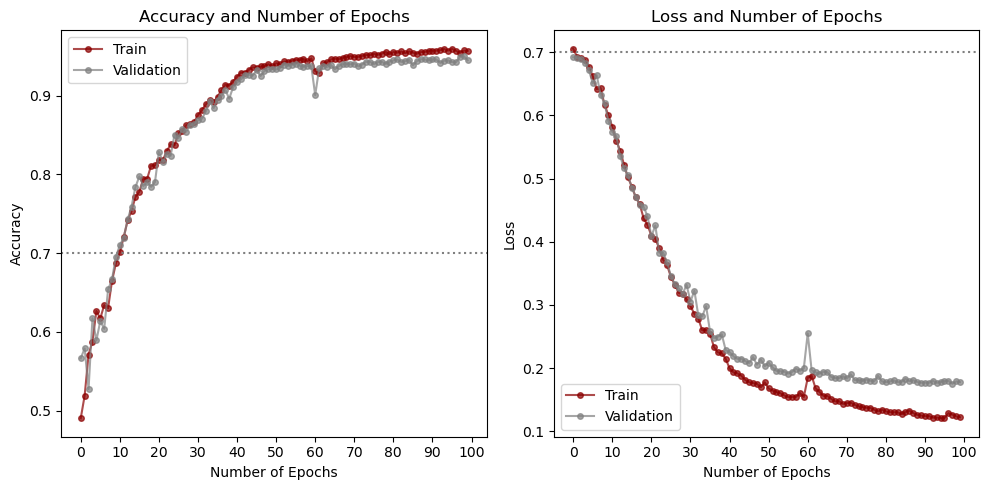

In [431]:
plot_res(train_acc, val_acc, train_loss, val_loss, ticks = 10)

The plot above shows the train and validation progress for the more complex CNN.  In this, we had 12,465 total parameters; luckily, they were all trainable.  We used the architecture: Input Layer, two Convolutional 2d Layers, a MaxPooling layer, a Flatten, and Output Layer. The first plot shows the accuracy and number of epochs. The second plot shows the loss and number of epochs. We see an increase in accuracy and a decrease in loss for both the train and validation sets. Compared to the ResNet, this graph is more accurate as it minimized the training and validation errors without extreme overfitting to the train data. Each complete iteration optimizes the parameters due to minimal loss or error between the predicted and actual outputs. 

When using this model, we get a training accuracy of 95.70%, a validation accuracy of 94.50%, and a test accuracy of 94.56%. 

## Experimental: SOTA TL No Tune

To improve our model, we decided to try a ResNet50v2 implementation with no fine-tuning to assess initial performance. Our images are much simpler than ResNet's original training set, for which we suspect overfitting may occur, especially with how "deep" of an architecture it has. Thus, we add early stopping to control overfitting by monitoring the validation loss with low patience.

In [432]:
model3 = ResNet50V2(include_top=False, weights='imagenet', input_shape=img_shape)
x = model3.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

for layer in model3.layers:
    layer.trainable = False

In [433]:
model3 = tf.keras.models.Model(inputs=model3.input, outputs=outputs, name = "SOTA_No_Tune")

model3.compile(optimizer=Adam(), 
               loss='binary_crossentropy', 
               metrics=["accuracy"])

model3.summary()

Model: "SOTA_No_Tune"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_49[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                                       

In [434]:
tf.keras.utils.plot_model(model3, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![My Image](resnet.png)

In [435]:
%%time
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, start_from_epoch = 10)

model3.fit(x_train, y_train, epochs=100, validation_split=0.2, batch_size = batch_size, callbacks = [es], verbose=0);

2023-05-08 18:54:46.641246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:54:46.641651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:54:51.117185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and sha

CPU times: user 12.5 s, sys: 1.6 s, total: 14.1 s
Wall time: 37.1 s


In [436]:
model3.save("data/models/project/model3")

INFO:tensorflow:Assets written to: data/models/project/model3/assets


INFO:tensorflow:Assets written to: data/models/project/model3/assets


In [437]:
train_acc, val_acc, train_loss, val_loss = save_results(model3, 'SOTA No Tune')

  7/259 [..............................] - ETA: 4s - loss: 0.3683 - accuracy: 0.8259

2023-05-08 18:55:38.913670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:55:38.914188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]


259/259 [==============================] - 3s 11ms/step - loss: 0.4307 - accuracy: 0.7963
Train accuracy is 85.52%
Validation accuracy is 79.94%
Test accuracy is 79.63%


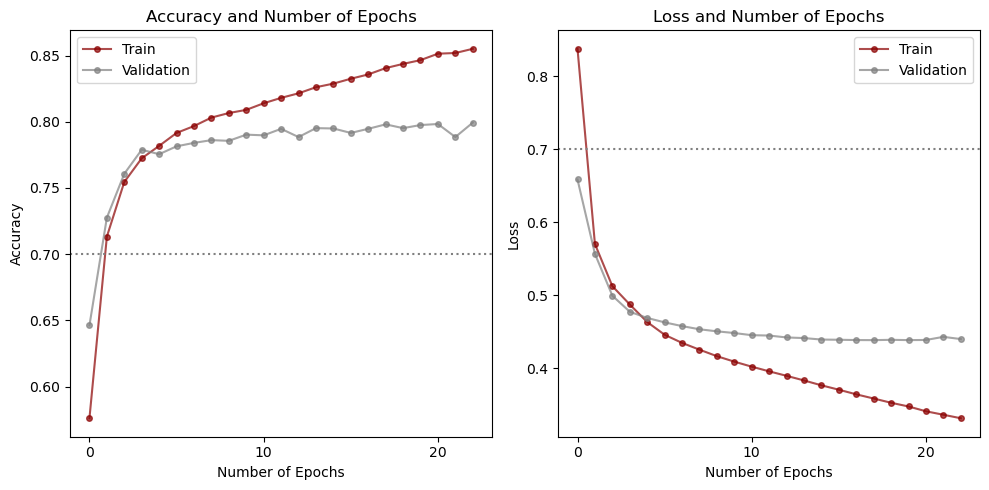

In [438]:
plot_res(train_acc, val_acc, train_loss, val_loss, ticks = 10)

- As we can see from the training and validation accuracy, the ResNet model is doing worse than our baseline and even terminated early due to no improvement for 5 epochs in validation loss. Training for longer may have provided some improvement in the accuracy, however it appears somewhat convergent even if we had increase patience.
- There were 25,664,001 total parameters in this model, with only 2,099,201 being trainable and 23,564,800 not being trainable. We stuck to Adam with the default setting for the optimizer and used binary cross entropy.
- This model is incredibly complex, and the architecture has a significant amount of layers we see discrepancies probably due to overfitting. 
This model isn't able to learn generalizable trends. The more complex CNN has superior performance and fewer parameters to train, making it more resource-friendly.

# Results

We used Gradcam and a Confusion Matrix to understand how the model worked. 

## Helper Functions

In [439]:
def generate_gradcam(model, img, class_index):
    gradcam = Gradcam(model)
    score = BinaryScore([class_index])
    gradcam_results = gradcam(score, img)
    return gradcam_results

def conf_matrix(y_test, y_test_class, title):
    cm = confusion_matrix(y_test, y_test_class)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Uninfected", "Infected"])
    display.plot()
    plt.title(f"Malaria infection\n {title}")
    plt.show()

    accuracy = round((cm[0][0] + cm[1][1]) / sum(sum(cm))*100,2)
    specificity = round((cm[0][0] / sum(cm[0, :])) * 100, 2)
    sensitivity = round((cm[1][1] / sum(cm[1, :])) * 100, 2)
    precision = round((cm[1][1] / sum(cm[:, 1])) * 100, 2)
    f1_score = round(2 * (precision * sensitivity) / (precision + sensitivity), 2)

    print(f"Accuracy: {accuracy}%")
    print(f"True Negative Rate: {specificity}%")
    print(f"True Positive Rate: {sensitivity}%")
    print(f"Precision: {precision}%")
    print(f"F1 Score: {f1_score}%")
    
def results_frame(results):
    data = [{'Model': key,
         'Train Accuracy': round(value[0], 2),
         'Validation Accuracy': round(value[1], 2),
         'Test Accuracy': round(value[2], 2)}
        for d in results for key, value in d.items()]

    return pd.DataFrame(data)

## Improved: More Complex CNN

In [440]:
y_test_pred = model2.predict(x_test)
threshold = 0.5
y_test_class = np.where(y_test_pred > threshold, 1, 0).reshape(-1,)

 35/259 [===>..........................] - ETA: 0s 

2023-05-08 18:55:42.494493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]
2023-05-08 18:55:42.494949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]


259/259 [==============================] - 1s 1ms/step


In [441]:
#Correctly classified
correct = (y_test_class == y_test.flatten())
c_arrs = x_test[correct]
c_labels = y_test[correct].flatten()
c_pred_labels =  y_test_class[correct]

#Correctly classified (True label = Uninfected)
c0_arrs = c_arrs[np.where(c_labels == 0)]
c0_labels = c_labels[np.where(c_labels == 0)]
c0_pred_labels = c_pred_labels[np.where(c_labels == 0)]

#Correctly classified (True label = Infected)
c1_arrs = c_arrs[np.where(c_labels == 1)]
c1_labels = c_labels[np.where(c_labels == 1)]
c1_pred_labels = c_pred_labels[np.where(c_labels == 1)]

In [442]:
#Incorrectly classified
incorrect = (y_test_class != y_test.flatten())
i_arrs = x_test[incorrect]
i_labels = y_test[incorrect].flatten()
i_pred_labels =  y_test_class[incorrect]

#Incorrectly classified (True label = Uninfected)
i0_arrs = i_arrs[np.where(i_labels == 0)]
i0_labels = i_labels[np.where(i_labels == 0)]
i0_pred_labels = i_pred_labels[np.where(i_labels == 0)]

#Incorrectly classified (True label = Infected)
i1_arrs = i_arrs[np.where(i_labels == 1)]
i1_labels = i_labels[np.where(i_labels == 1)]
i1_pred_labels = i_pred_labels[np.where(i_labels == 1)]

In [443]:
classdict = {0: 'Uninfected', 1: 'Infected'}

i = 0
c0_arr = c0_arrs[i]
c1_arr = c1_arrs[i]
i0_arr = i0_arrs[i]
i1_arr = i1_arrs[i]
c0_label = c0_labels[i]
c1_label = c1_labels[i]
i0_label = i0_labels[i]
i1_label = i1_labels[i]
c0_pred_label = c0_pred_labels[i]
c1_pred_label = c1_pred_labels[i]
i0_pred_label = i0_pred_labels[i]
i1_pred_label = i1_pred_labels[i]
gc_c0 = generate_gradcam(model2, c0_arr, c0_label)[0]
gc_c1 = generate_gradcam(model2, c1_arr, c1_label)[0]
gc_i0 = generate_gradcam(model2, i0_arr, i0_label)[0]
gc_i1 = generate_gradcam(model2, i1_arr, i1_label)[0]

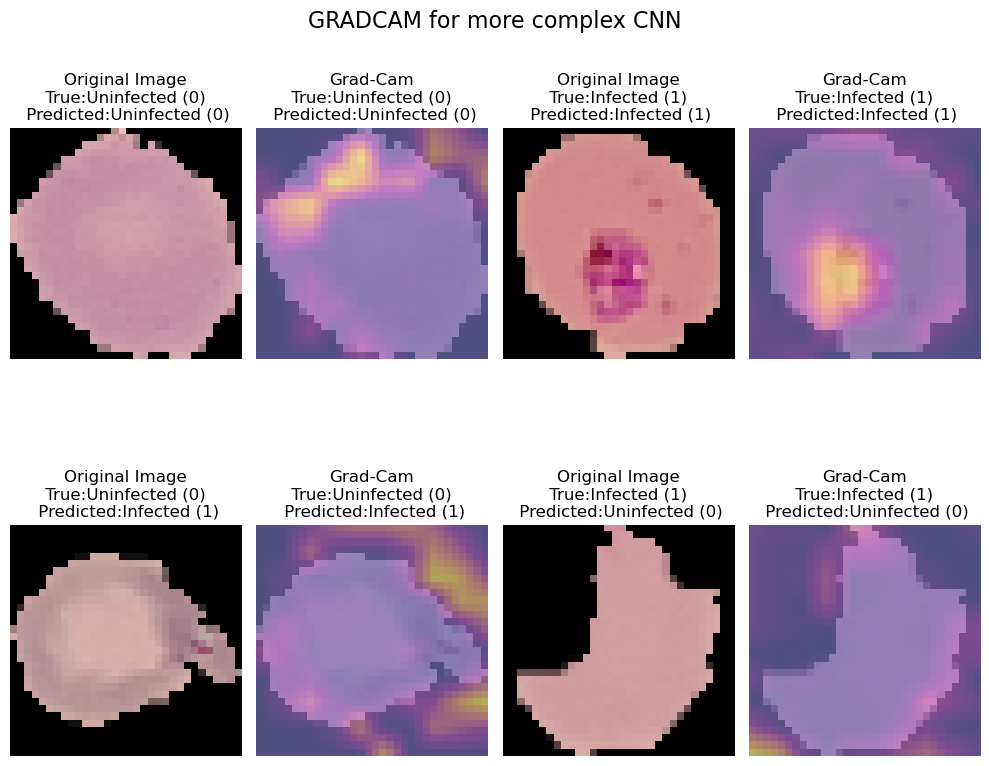

In [444]:
fig, axs = plt.subplots(2, 4, figsize=(10,9))
axs = axs.ravel()
titles = ["Original Image","Grad-Cam"]*4
labels = [c0_label, c1_label, i0_label, i1_label]
labels = [x for x in labels for _ in range(2)]

pred_labels = [c0_pred_label, c1_pred_label, i0_pred_label, i1_pred_label]
pred_labels = [x for x in pred_labels for _ in range(2)]

axs[0].imshow(c0_arr)
axs[1].imshow((c0_arr+1)/2)
axs[1].imshow(gc_c0, cmap="plasma", alpha=0.4)

axs[2].imshow(c1_arr)
axs[3].imshow((c1_arr+1)/2)
axs[3].imshow(gc_c1, cmap="plasma", alpha=0.4)

axs[4].imshow(i0_arr)
axs[5].imshow((i0_arr+1)/2)
axs[5].imshow(gc_i0, cmap="plasma", alpha=0.4)

axs[6].imshow(i1_arr)
axs[7].imshow((i1_arr+1)/2)
axs[7].imshow(gc_i1, cmap="plasma", alpha=0.4)

for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.axis("off")
    ax.set_title(f"{title}\n True:{classdict[labels[i]]} ({int(labels[i])}) \n Predicted:{classdict[pred_labels[i]]} ({pred_labels[i]})")
plt.tight_layout()
fig.suptitle('GRADCAM for more complex CNN', fontsize=16)
plt.show()

From the above image, we see the more complex CNN (which has superior performance) is finding the regions of infection we notice have higher saturation of purple. Where infection isn't present, this model seems to confuse abnormal cell edges with infection, which may indicate it has associated such rigid shapes or high color contrast with infection rather than the "purple" patches we see as humans.

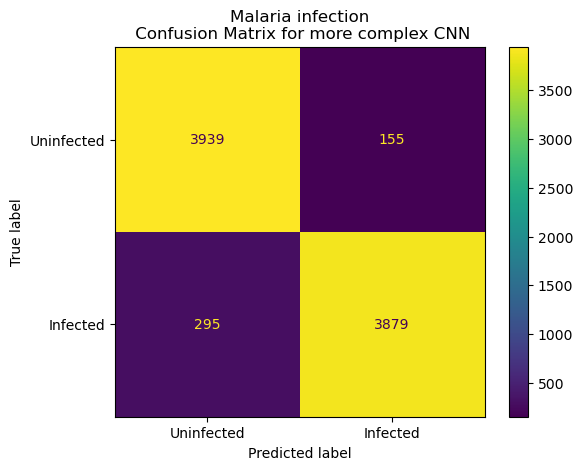

Accuracy: 94.56%
True Negative Rate: 96.21%
True Positive Rate: 92.93%
Precision: 96.16%
F1 Score: 94.52%


In [445]:
conf_matrix(y_test, y_test_class, "Confusion Matrix for more complex CNN")

In the confusion matrix above, we can see that the majority of images are correctly classified, but there still are 295 infected cells that are classified as uninfected. Interestingly, the model is better recognizing a cell is uninfected than it is at detecting a cell is infected. This may have to do with images being predominately empty (padding) or uninfected cell apperance. Infectious regions are usually quite small. 

## Experimental: SOTA TL No Tune

In [446]:
#Prediction of the Resnet model
y_test_pred = model3.predict(x_test)
threshold = 0.5
y_test_class = np.where(y_test_pred > threshold, 1, 0).reshape(-1,)

2023-05-08 18:55:44.439277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]
2023-05-08 18:55:44.439666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]


259/259 [==============================] - 3s 8ms/step


In [447]:
#Correctly classified
correct = (y_test_class == y_test.flatten())
c_arrs = x_test[correct]
c_labels = y_test[correct].flatten()
c_pred_labels =  y_test_class[correct]

#Correctly classified (True label = Uninfected)
c0_arrs = c_arrs[np.where(c_labels == 0)]
c0_labels = c_labels[np.where(c_labels == 0)]
c0_pred_labels = c_pred_labels[np.where(c_labels == 0)]

#Correctly classified (True label = Infected)
c1_arrs = c_arrs[np.where(c_labels == 1)]
c1_labels = c_labels[np.where(c_labels == 1)]
c1_pred_labels = c_pred_labels[np.where(c_labels == 1)]

In [448]:
#Incorrectly classified
incorrect = (y_test_class != y_test.flatten())
i_arrs = x_test[incorrect]
i_labels = y_test[incorrect].flatten()
i_pred_labels =  y_test_class[incorrect]

#Incorrectly classified (True label = Uninfected)
i0_arrs = i_arrs[np.where(i_labels == 0)]
i0_labels = i_labels[np.where(i_labels == 0)]
i0_pred_labels = i_pred_labels[np.where(i_labels == 0)]

#Incorrectly classified (True label = Infected)
i1_arrs = i_arrs[np.where(i_labels == 1)]
i1_labels = i_labels[np.where(i_labels == 1)]
i1_pred_labels = i_pred_labels[np.where(i_labels == 1)]

In [449]:
classdict = {0: 'Uninfected', 1: 'Infected'}

i = 0
c0_arr = c0_arrs[i]
c1_arr = c1_arrs[i]
i0_arr = i0_arrs[i]
i1_arr = i1_arrs[i]
c0_label = c0_labels[i]
c1_label = c1_labels[i]
i0_label = i0_labels[i]
i1_label = i1_labels[i]
c0_pred_label = c0_pred_labels[i]
c1_pred_label = c1_pred_labels[i]
i0_pred_label = i0_pred_labels[i]
i1_pred_label = i1_pred_labels[i]
gc_c0 = generate_gradcam(model2, c0_arr, c0_label)[0]
gc_c1 = generate_gradcam(model2, c1_arr, c1_label)[0]
gc_i0 = generate_gradcam(model2, i0_arr, i0_label)[0]
gc_i1 = generate_gradcam(model2, i1_arr, i1_label)[0]

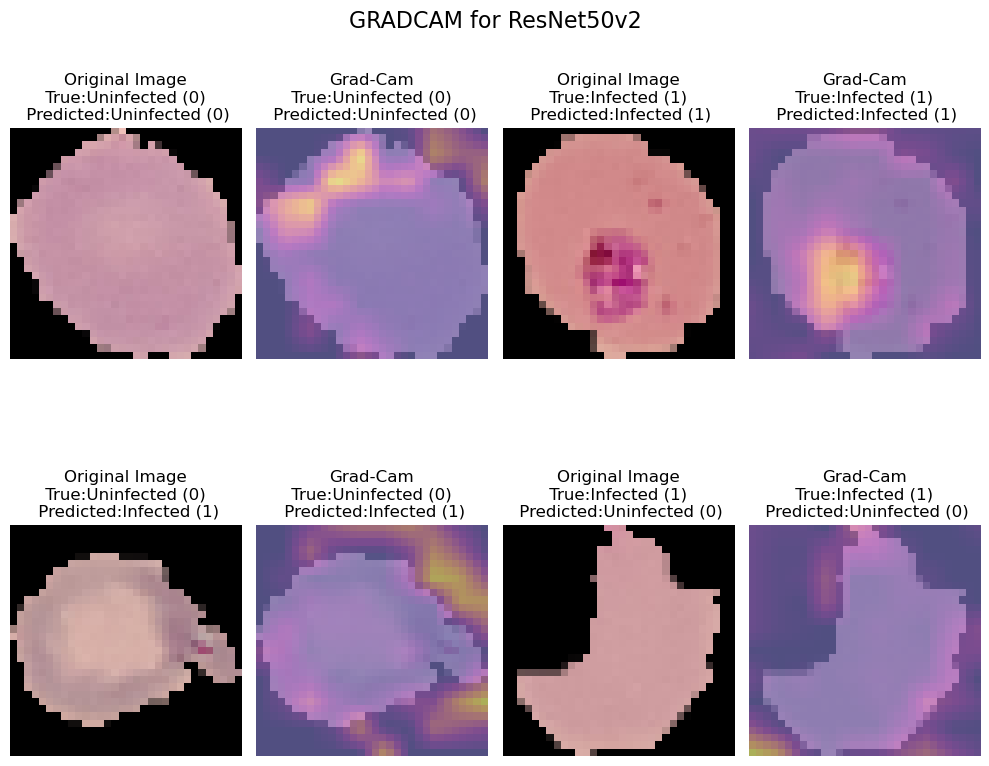

In [450]:
fig, axs = plt.subplots(2, 4, figsize=(10,9))
axs = axs.ravel()
titles = ["Original Image","Grad-Cam"]*4
labels = [c0_label, c1_label, i0_label, i1_label]
labels = [x for x in labels for _ in range(2)]

pred_labels = [c0_pred_label, c1_pred_label, i0_pred_label, i1_pred_label]
pred_labels = [x for x in pred_labels for _ in range(2)]

axs[0].imshow(c0_arr)
axs[1].imshow((c0_arr+1)/2)
axs[1].imshow(gc_c0, cmap="plasma", alpha=0.4)

axs[2].imshow(c1_arr)
axs[3].imshow((c1_arr+1)/2)
axs[3].imshow(gc_c1, cmap="plasma", alpha=0.4)

axs[4].imshow(i0_arr)
axs[5].imshow((i0_arr+1)/2)
axs[5].imshow(gc_i0, cmap="plasma", alpha=0.4)

axs[6].imshow(i1_arr)
axs[7].imshow((i1_arr+1)/2)
axs[7].imshow(gc_i1, cmap="plasma", alpha=0.4)

for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.axis("off")
    ax.set_title(f"{title}\n True:{classdict[labels[i]]} ({int(labels[i])}) \n Predicted:{classdict[pred_labels[i]]} ({pred_labels[i]})")
plt.tight_layout()
fig.suptitle('GRADCAM for ResNet50v2', fontsize=16)
plt.show()

From the above image, we see the more complex CNN (which has superior performance) is finding the regions of infection we notice have higher saturation of purple. Where infection isn't present, this model seems to confuse abnormal cell edges with infection, which may indicate it has associated such rigid shapes or high color contrast with infection rather than the "purple" patches we see as humans.

While predicted from the ResNet50v2, we see this result is almost identical to the previous GradCAM of the more complex CNN. Given this model is more complex and yet is looking at the same regions, it may be more easily tricked by the provided possibilties above.

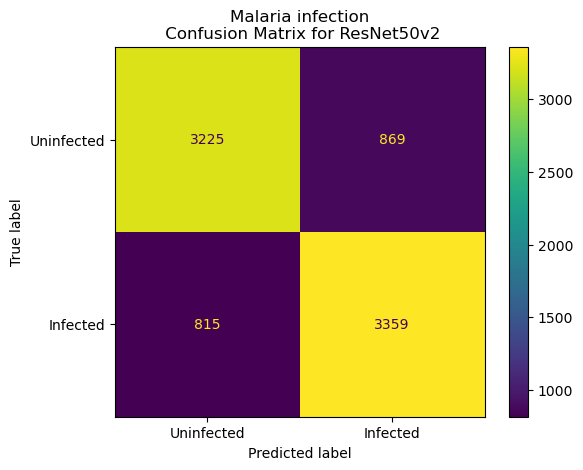

Accuracy: 79.63%
True Negative Rate: 78.77%
True Positive Rate: 80.47%
Precision: 79.45%
F1 Score: 79.96%


In [451]:
conf_matrix(y_test, y_test_class, "Confusion Matrix for ResNet50v2")

In the confusion matrix above, we can see that the majority of images are correctly classified, but a large number of infected cells (815) are incorrectly classified as uninfected, which is a main concern. Interestingly, this model is better recognizing a cell is infected than it is at detecting a cell is uninfected. Given the model is overfitting, it is likely better at noticing the comparitively small parts of the image that are infectious regions of the cell. 

## Model Comparisons

In [452]:
# Show the current state of the results
results_frame(results)

,Model,Train Accuracy,Validation Accuracy,Test Accuracy
0,Baseline CNN,0.59,0.59,0.59
1,Complex CNN,0.96,0.95,0.95
2,SOTA No Tune,0.86,0.80,0.80


We first decided to utilize techniques like GradCam to improve the interpretability of our models. Being aware that neural networks (and, thus, convolutional neural networks) are often deemed black boxes because people often have difficulty understanding how predictions are made and are pretty hard to interpret. Therefore, utilizing approaches like GradCam would allow us to better understand how the models made predictions and confirm that the models are not learning undesired patterns in the images (such as the background).

In terms of the models we chose, we first tried to achieve better performance relative to our baseline model by implementing a SOTA model (ResNet) because it is a well-developed and studied algorithm that often has good performance. Nevertheless, such an approach did not perform as well as we expected, as it seemed to be too complex and led to overfitting. Therefore, we decided to return to our original baseline model (which had done relatively better and did not have overfitting issues) to slowly increase its complexity and achieve better results. Overall, such a more complex CNN (not SOTA model) increased our test accuracy without raising overfitting concerns, thus being the model chosen. 

# 209B: False Negative GradCAM Study

To start exploring potential 209 topics, we first plotted the GradCAM again but only for False Negatives. We deemed of highest importance in this study to accurately predict cells that were infected, as fast detection of disease can help people get access to treatment as quickly as possible and, thus, improve their chances of overcoming the disease.

In [453]:
random_vector = [random.randint(0, i1_arrs.shape[0]) for _ in range(4)]

In [454]:
gc_i1s_list = []
for i in range(4):
    gc_i1s = generate_gradcam(model2, i1_arrs[random_vector][i], i1_labels[random_vector][i])
    gc_i1s_list.append(gc_i1s)

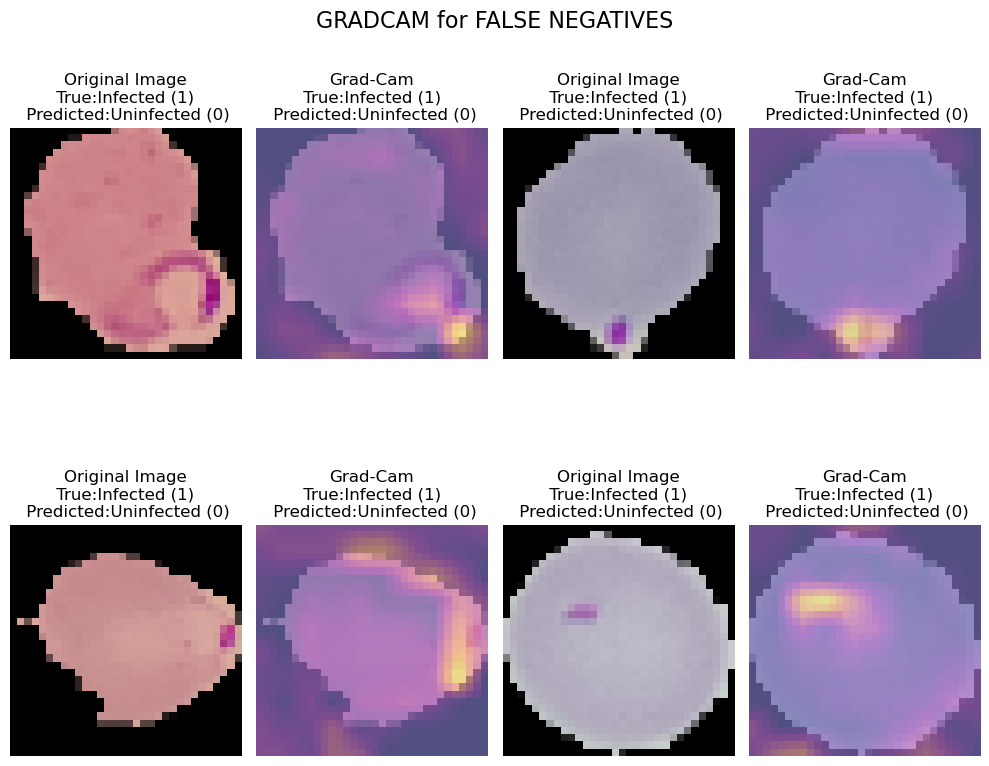

In [455]:
fig, axs = plt.subplots(2, 4, figsize=(10,9))
axs = axs.ravel()
titles = ["Original Image","Grad-Cam"]*4
labels = i1_labels[:4]
labels = [x for x in labels for _ in range(2)]

pred_labels = i1_pred_labels[:4]
pred_labels = [x for x in pred_labels for _ in range(2)]

for i in range(0, 4, 1):
    axs[i*2].imshow(i1_arrs[random_vector][i])
    axs[i*2+1].imshow((i1_arrs[random_vector][i]+1)/2)
    axs[i*2+1].imshow(gc_i1s_list[i][0], cmap="plasma", alpha=0.4)

for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.axis("off")
    ax.set_title(f"{title}\n True:{classdict[labels[i]]} ({int(labels[i])}) \n Predicted:{classdict[pred_labels[i]]} ({pred_labels[i]})")
plt.tight_layout()
fig.suptitle('GRADCAM for FALSE NEGATIVES', fontsize=16)
plt.show()

As we can see in the plots above, the CNN may not be looking at the right places when predicting that an infected cell is uninfected. 

## Transforming Image Hue & Saturation

- Dzubay, J.A., Jerusalmi, A., Jesudason, R. et al. An image analysis algorithm based on the hue saturation density transformation, an important tool for melanoma immunotherapy research. j. immunotherapy cancer 2 (Suppl 3), P134 (2014). https://doi.org/10.1186/2051-1426-2-S3-P134
    - This paper struggled with detecting melanoma since the melanocytes (cancer causing cells) have brown melanin that confounds with the stains which are usually brown or red. They found that using definiens' stain isolation algorithm which hinges on the traditional Hue-Saturation-Density (HSD) transformation was able to seperate the colors enough to produce increased accuracy during detection.
    - Many other areas have used HSI (Hue, Saturation, Density) alterations since certain colors and features stand out in different visual channels. This is especially true in literature relating to immunotherapy and the dye applied to tumor cell specimens, since they can conflict with infectious presence and be non-standardized within the field.

Upon reviewing our data (images both for infected and uninfected cells), we noticed that the hue presented in the images varied quite a lot, likely due to the dye utilized in the lab when examining the images. The hues identified included shades of pink, purple, and blue. Therefore, to improve our models, we investigated the outcome of performing data preprocessing to randomly change the color of the images to these hues. Moreover, due to the research cited above on the efficacy of changing saturation levels for model performance, we changed the saturation of the images on such additional preprocessing step. 

In [456]:
def transforming_images(images):
    # Define the color jittering parameters
    num_images = images.shape[0]
    hue_shifts = np.random.randint(-10, 11, size=num_images)
    hue_shifts = np.where(hue_shifts >= 0, hue_shifts + 130, hue_shifts + 230)
    saturation_factors = np.random.uniform(0.5, 1.5, size=num_images)
    value_factors = np.random.uniform(0.5, 1.5, size=num_images)

    # Define the desired hue range for purple and pink colors
    lower_purple_hue = 130
    upper_purple_hue = 170
    lower_pink_hue = 170
    upper_pink_hue = 230    
    
# Apply the color jittering transformations in a loop
    images_mod = []
    for i in range(images.shape[0]):
        # Convert image to HSV color space
        image_hsv = cv2.cvtColor((images[i]*255).astype(np.uint8), cv2.COLOR_BGR2HSV)

        # Set hue values outside the desired purple and pink hue range to zero
        purple_mask = cv2.inRange(image_hsv, (lower_purple_hue, 0, 0), (upper_purple_hue, 255, 255))
        pink_mask = cv2.inRange(image_hsv, (lower_pink_hue, 0, 0), (upper_pink_hue, 255, 255))
        image_hsv[..., 0] = np.where(purple_mask + pink_mask > 0, image_hsv[..., 0], 0)

        # Apply hue shift
        image_hsv[..., 0] = np.clip(image_hsv[..., 0] + hue_shifts[i], 0, 179)

        # Apply saturation and value factors
        image_hsv[..., 1] = np.clip(image_hsv[..., 1] * saturation_factors[i], 0, 255)
        image_hsv[..., 2] = np.clip(image_hsv[..., 2] * value_factors[i], 0, 255)

        # Convert image back to BGR color space
        image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)/255.0

        # Save the transformed image
        images_mod.append(image)

    images_mod = np.asarray(images_mod)
    
    return images_mod


In [457]:
x_train_mod = transforming_images(x_train)
x_test_mod = transforming_images(x_test)

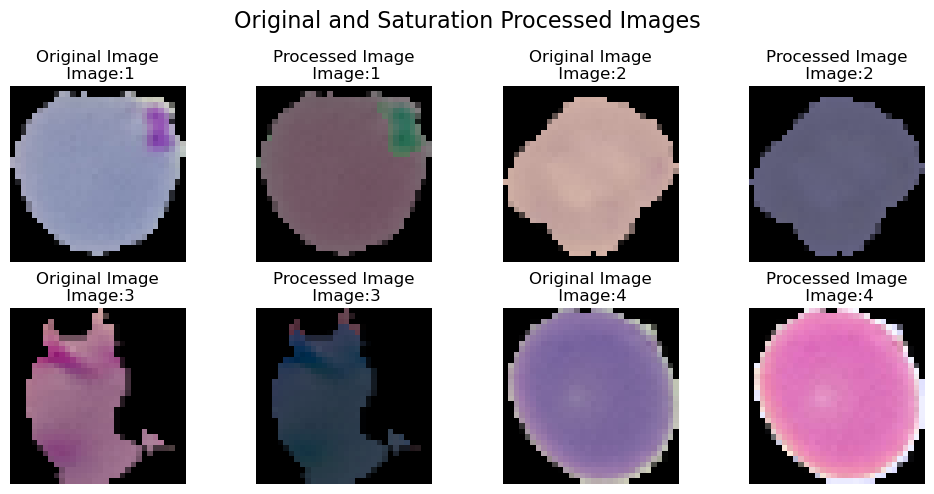

In [458]:
fig, axs = plt.subplots(2, 4, figsize=(10,5))
axs = axs.ravel()

titles = ["Original Image","Processed Image"]*4
labels = i1_labels[:4]
labels = [x for x in labels for _ in range(2)]

for i in range(0, 4, 1):
    axs[i*2].imshow(x_train[random_vector][i])
    axs[i*2+1].imshow(x_train_mod[random_vector][i])

fig.suptitle('Original and Saturation Processed Images', fontsize=16)

for i, (ax, title) in enumerate(zip(axs, titles), start=1):
    ax.axis("off") 
    image_number = (i + 1) // 2 
    ax.set_title(f"{title}\n Image:{image_number}") 
    
plt.tight_layout()  

As we can see above, while the distinct features of the images remained unchanged, the hues utilized differed, and the saturation allows for more easy detection of places where infections occur without adding artificial noise to the uninfected cells.

## Improved: Complex CNN with Further Data Preprocessing (Altering Image Hue & Saturation)

We first fit a new neural network with the exact same architecture as the Model2 previously shown (which had the best performance), but including the preprocessing steps defined above. In this case, any data that the CNN sees would have to receive the same transformation technique. We transformed both the train and test sets by altering image hue and saturation. 

In [459]:
model2b = build_model(img_shape, conv_pool_layers=2, num_filters=16, kernel_size=3, padding="same", model_name = "Complex_CNN_Data_Preprocessing")

model2b.compile(optimizer=Adam(1e-2), 
               loss='binary_crossentropy', 
               metrics=["accuracy"])

model2b.summary()

Model: "Complex_CNN_Data_Preprocessing"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 10, 10, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 3, 3, 16)         0         
 ng2D)                                                           
                                                                 
 flatten_49 (Flatten)        (None, 

In [460]:
tf.keras.utils.plot_model(model2b, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![My Image](improved_flow.png)

In [461]:
%%time
model2b.fit(x_train_mod, y_train, epochs = 100, validation_split = 0.2, batch_size = batch_size, verbose=0);

2023-05-08 18:55:54.856761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:55:54.857287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:55:56.798574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and sha

CPU times: user 23.4 s, sys: 4.32 s, total: 27.7 s
Wall time: 30.7 s


In [462]:
train_acc2b, val_acc2b, train_loss2b, val_loss2b = save_results(model2b, 'Complex CNN Data Preprocessing')

 80/259 [========>.....................] - ETA: 0s - loss: 0.2634 - accuracy: 0.8945

2023-05-08 18:56:25.335250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:56:25.335611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]


259/259 [==============================] - 1s 2ms/step - loss: 0.2885 - accuracy: 0.8799
Train accuracy is 92.28%
Validation accuracy is 89.71%
Test accuracy is 87.99%


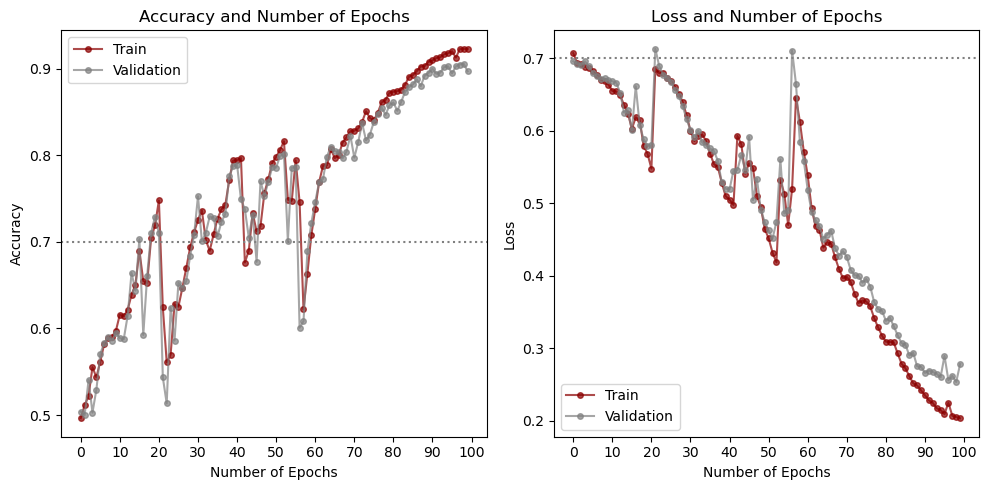

In [463]:
plot_res(train_acc2b, val_acc2b, train_loss2b, val_loss2b, ticks = 10)

We can see that the plots is  relatively convergent, also there is not a big difference between training and test, meaning that it is not overfitting. However there are some  big 'jumps' in both plots, which might imply instability with the optimizer rate.

In [464]:
y_test_pred2b = model2b.predict(x_test_mod)
threshold = 0.5
y_test_class2b = np.where(y_test_pred2b > threshold, 1, 0).reshape(-1,)

 72/259 [=======>......................] - ETA: 0s

2023-05-08 18:56:26.538509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]
2023-05-08 18:56:26.538973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]


259/259 [==============================] - 0s 1ms/step


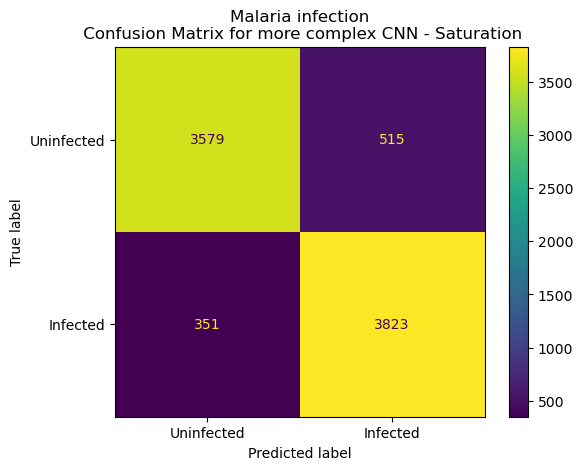

Accuracy: 89.53%
True Negative Rate: 87.42%
True Positive Rate: 91.59%
Precision: 88.13%
F1 Score: 89.83%


In [465]:
conf_matrix(y_test, y_test_class2b, "Confusion Matrix for more complex CNN - Saturation")

In the confusion matrix above, we can see that the majority of images are correctly classified, but there still are 351 infected cells that are classified as uninfected, which is higher than some of the previous models.

## Improved: Complex CNN with Data Augmentation

Duplicating Training Set: Altering Image Hue & Saturation

Since the previous CNN tried did not improve performance as much as we had expected, we tried incorporating the preprocessing steps in a new way (but keeping the CNN architecture unchanged). Instead, we utilized such steps as part of a manual data augmentation mechanism. Since having more data often leads to better model performance, we concatenated the original images in the training set with a modified version of such images (with altered hue and saturation). Since we are not engaging in further data preprocessing and we are merely increasing our training set, the test dataset remained unchanged and so would additional data that our model would get to make inferences. This technique allowed us to duplicate our training set size.

In [466]:
model2c = build_model(img_shape, conv_pool_layers=2, num_filters=16, kernel_size=3, padding="same", model_name = 'Complex_CNN_Data_Augmentation')

model2c.compile(optimizer=Adam(1e-2), 
               loss='binary_crossentropy', 
               metrics=["accuracy"])

model2c.summary()

Model: "Complex_CNN_Data_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_67 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_106 (MaxPooli  (None, 10, 10, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_68 (Conv2D)          (None, 10, 10, 16)        2320      
                                                                 
 max_pooling2d_107 (MaxPooli  (None, 3, 3, 16)         0         
 ng2D)                                                           
                                                                 
 flatten_50 (Flatten)        (None, 1

In [467]:
tf.keras.utils.plot_model(model2c, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![My Image](improved_flow.png)

In [468]:
%%time
model2c.fit(np.concatenate((x_train, x_train_mod), axis=0), np.concatenate((y_train, y_train), axis=0), 
        epochs=100,
        validation_split=0.2,
        batch_size = batch_size,
        verbose=0);

2023-05-08 18:56:30.812864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [30864,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:56:30.813277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [30864,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:56:32.998382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and sha

CPU times: user 42 s, sys: 10.6 s, total: 52.6 s
Wall time: 58.4 s


In [469]:
train_acc2c, val_acc2c, train_loss2c, val_loss2c = save_results(model2c, 'Complex CNN Data Augmentation')

 80/259 [========>.....................] - ETA: 0s - loss: 0.1701 - accuracy: 0.9371

2023-05-08 18:57:26.209717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:57:26.210093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]


259/259 [==============================] - 1s 2ms/step - loss: 0.1832 - accuracy: 0.9330
Train accuracy is 94.75%
Validation accuracy is 91.33%
Test accuracy is 93.30%


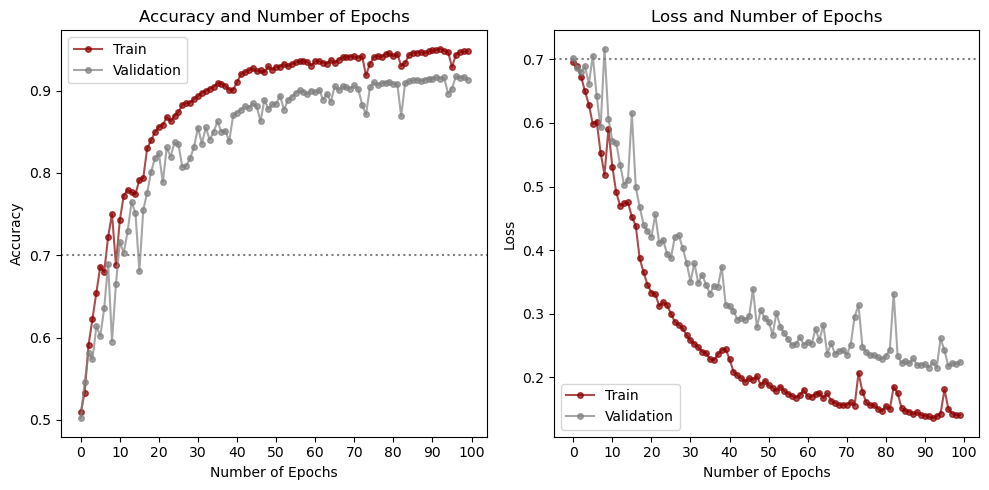

In [470]:
plot_res(train_acc2c, val_acc2c, train_loss2c, val_loss2c, ticks = 10)

In the plots above, we can argue the plots show relative convergence, even though there is some difference between train and test accuracy and loss.

In [471]:
y_test_pred2c = model2c.predict(x_test)
threshold = 0.5
y_test_class2c = np.where(y_test_pred2c > threshold, 1, 0).reshape(-1,)

 72/259 [=======>......................] - ETA: 0s

2023-05-08 18:57:27.499312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]
2023-05-08 18:57:27.499644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]


259/259 [==============================] - 0s 1ms/step


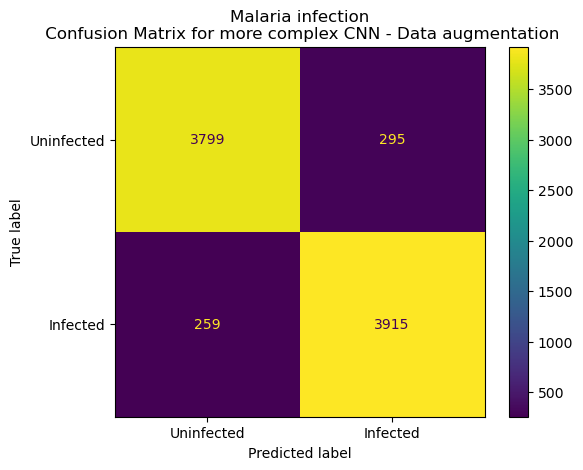

Accuracy: 93.3%
True Negative Rate: 92.79%
True Positive Rate: 93.79%
Precision: 92.99%
F1 Score: 93.39%


In [472]:
cm = conf_matrix(y_test, y_test_class2c, "Confusion Matrix for more complex CNN - Data augmentation")

In the confusion matrix above, we can see that the majority of images are correctly classified, but there still are 259 infected cells that are classified as uninfected. Nevertheless, the true positive rate is high. 

## More Complex Model with Data Augmentation

Duplicating Training Set (Altering Image Hue & Saturation) and using a more complex model architecture

We tried one last approach to increase our model performance. In this case, we kept the data augmentation procedure as described in model 2c but we changed our model architecture to be more complex. 

In [473]:
model2d = build_model(img_shape, conv_pool_layers=3, num_filters=32, kernel_size=3, padding="same", model_name = 'More_Complex_CNN_Data_Augmentation')

model2d.compile(optimizer=Adam(), 
               loss='binary_crossentropy', 
               metrics=["accuracy"])

model2d.summary()

Model: "More_Complex_CNN_Data_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 10, 10, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_109 (MaxPooli  (None, 3, 3, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (No

In [474]:
tf.keras.utils.plot_model(model2d, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![My Image](model2d_flow.png)

In [475]:
%time
model2d.fit(np.concatenate((x_train, x_train_mod), axis=0), np.concatenate((y_train, y_train), axis=0), 
        epochs=100,
        validation_split=0.2,
        batch_size = batch_size,
        verbose=0);

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


2023-05-08 18:57:29.792427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [30864,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:57:29.792983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [30864,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:57:32.360454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and sha

In [476]:
train_acc2d, val_acc2d, train_loss2d, val_loss2d = save_results(model2d, 'More Complex CNN Data Augmentation')

 76/259 [=======>......................] - ETA: 0s - loss: 0.1460 - accuracy: 0.9465

2023-05-08 18:58:39.984786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:58:39.985134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]


259/259 [==============================] - 1s 2ms/step - loss: 0.1614 - accuracy: 0.9401
Train accuracy is 94.34%
Validation accuracy is 91.28%
Test accuracy is 94.01%


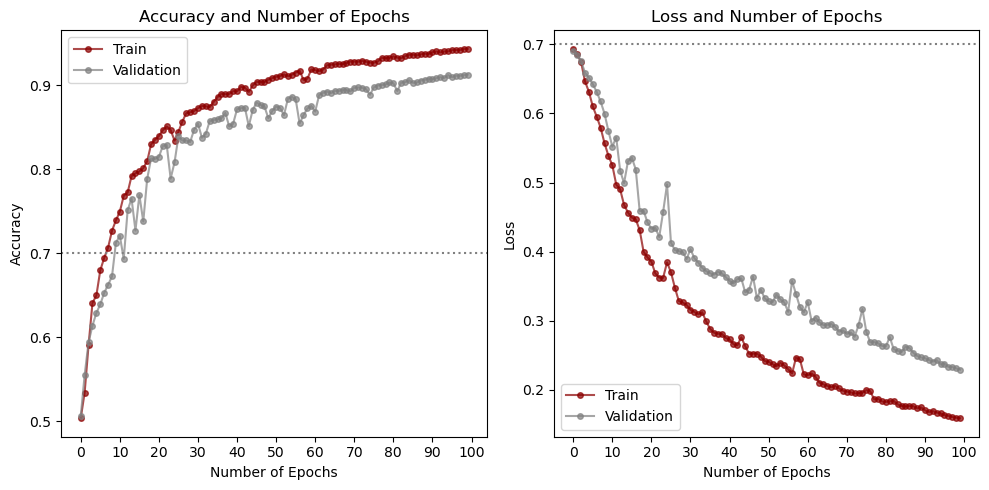

In [477]:
plot_res(train_acc2d, val_acc2d, train_loss2d, val_loss2d, ticks = 10)

In the plots above, we can argue the plots show relative convergence, even though there is some difference between train and test accuracy and loss.

In [478]:
y_test_pred2d = model2d.predict(x_test)
threshold = 0.5
y_test_class2d = np.where(y_test_pred2d > threshold, 1, 0).reshape(-1,)

 68/259 [======>.......................] - ETA: 0s

2023-05-08 18:58:41.279839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]
2023-05-08 18:58:41.280173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]


259/259 [==============================] - 1s 2ms/step


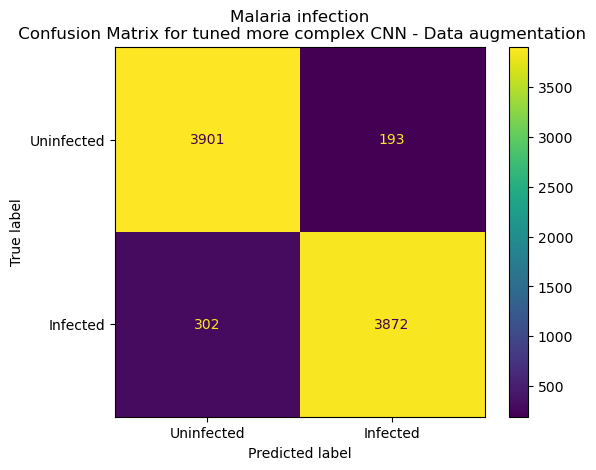

Accuracy: 94.01%
True Negative Rate: 95.29%
True Positive Rate: 92.76%
Precision: 95.25%
F1 Score: 93.99%


In [479]:
cm = conf_matrix(y_test, y_test_class2d, "Confusion Matrix for tuned more complex CNN - Data augmentation")

In the confusion matrix above, we can see that the majority of images are correctly classified, but there still are 302 infected cells that are classified as uninfected, which is higher than the previous model.

Unfortunately, none of the three models tried actually fulfilled our goal of reducing the False Negative rate. Although the accuracy attained was different between all of the models, none of them outperformed the original ones described before the 209 explorations. 

# 209B : Improving the ResNet Model 

ResNet models are large, and require more of a fine-tune strategy. Thus, rather than try to alter the early layers, which should be learning more basic, universal image features, we tried two approaches:

- Train the head we attached as well as the final batch normalization and convolution layer. This requires us to go back 7 layers, since there are intermediate "layers" with no trainable parameters
- Train the head we attached as well as the last two batch normalizations and convolution layers. This requires us to go back 19 layers, since yet again there are intermediate "layers" with no trainable parameters. This also happens to be 10% of the network, so we're training the last 10% of the network.

## Unfreezing Final 7 Layers

In [480]:
model4 = ResNet50V2(include_top=False, weights='imagenet', input_shape=img_shape)
x = model4.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

freeze_until_layer = -7
for layer in model4.layers[:freeze_until_layer]:
    layer.trainable = False
    
model4 = tf.keras.models.Model(inputs=model4.input, outputs=outputs, name = 'ResNet_Unfreezing_Last_7_Layers')

In [481]:
tf.keras.utils.plot_model(model4, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![My Image](resnet.png)

In [482]:
print(len(model4.layers))

# Checking what we're actually training (some don't have trainable parameters)
model4.layers[freeze_until_layer:]

193


In [483]:
model4.compile(optimizer=Adam(), 
               loss='binary_crossentropy', 
               metrics=["accuracy"])

model4.summary()

Model: "ResNet_Unfreezing_Last_7_Layers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_53[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                    

In [484]:
%%time
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, start_from_epoch = 10)

model4.fit(x_train, y_train, 
        epochs=100,
        validation_split=0.2,
        batch_size = batch_size,
        callbacks = [es],
        verbose=0);

2023-05-08 18:58:45.884643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:58:45.885173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:58:51.626350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and sha

CPU times: user 15.6 s, sys: 2.78 s, total: 18.4 s
Wall time: 42.5 s


In [485]:
train_acc, val_acc, train_loss, val_loss = save_results(model4, 'ResNet Unfreezing Last 7 Layers')

 16/259 [>.............................] - ETA: 2s - loss: 0.8102 - accuracy: 0.7891

2023-05-08 18:59:28.263793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:59:28.264195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]


259/259 [==============================] - 3s 10ms/step - loss: 0.8890 - accuracy: 0.7473
Train accuracy is 99.66%
Validation accuracy is 76.33%
Test accuracy is 74.73%


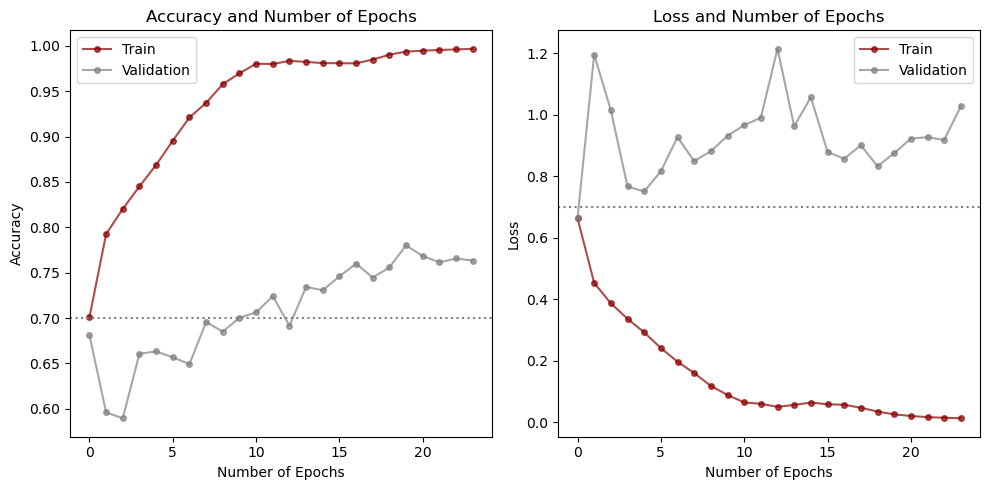

In [486]:
plot_res(train_acc, val_acc, train_loss, val_loss, ticks = 5)

It is apparent that the model is overfitting since there exists a significant disparity between the training accuracy (99.66%) and the test accuracy (74.73%).

In [487]:
y_test_pred = model4.predict(x_test)
threshold = 0.5
y_test_class = np.where(y_test_pred > threshold, 1, 0).reshape(-1,)

2023-05-08 18:59:31.478400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]
2023-05-08 18:59:31.478721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]


259/259 [==============================] - 3s 8ms/step


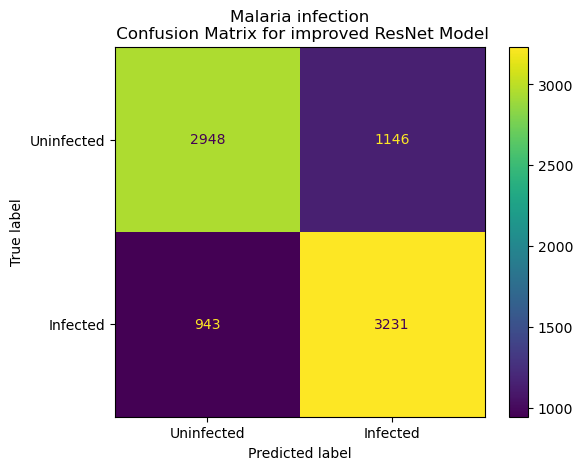

Accuracy: 74.73%
True Negative Rate: 72.01%
True Positive Rate: 77.41%
Precision: 73.82%
F1 Score: 75.57%


In [488]:
cm = conf_matrix(y_test, y_test_class, "Confusion Matrix for improved ResNet Model")

In the confusion matrix above, we can see that quite a large proportion of uninfected cells are incorrectly classified as infected. Moreover, there is a very large number (943) of infected cells that are misclassified as uninfected, which goes against our goal of reducing False Negatives. 

To reduce overfitting, we decide to train more layers:

## Unfreezing Final 19 Layers

In [489]:
model5 = ResNet50V2(include_top=False, weights='imagenet', input_shape=img_shape)
x = model5.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

freeze_until_layer = -19
for layer in model5.layers[:freeze_until_layer]:
    layer.trainable = False

    
model5 = tf.keras.models.Model(inputs=model5.input, outputs=outputs, name = 'ResNet_Unfreezing_Last_19_Layers')

In [490]:
model5.compile(optimizer=Adam(1e-5), 
               loss='binary_crossentropy', 
               metrics=["accuracy"])

model5.summary()

Model: "ResNet_Unfreezing_Last_19_Layers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_54[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                   

In [491]:
tf.keras.utils.plot_model(model5, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![My Image](resnet.png)

In [492]:
# Checking what we're actually training (some don't have trainable parameters)
model5.layers[freeze_until_layer:]

In [493]:
%%time
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, start_from_epoch = 10)

model5.fit(x_train, y_train, 
        epochs=100,
        validation_split=0.2,
        batch_size = batch_size,
        callbacks = [es],
        verbose=0);

2023-05-08 18:59:36.938982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:59:36.939407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [15432,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 18:59:44.126738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and sha

CPU times: user 52.6 s, sys: 16.5 s, total: 1min 9s
Wall time: 2min 25s


In [494]:
train_acc, val_acc, train_loss, val_loss = save_results(model5, 'ResNet Unfreezing Last 19 Layers')

 16/259 [>.............................] - ETA: 2s - loss: 0.5215 - accuracy: 0.7812

2023-05-08 19:02:02.275039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]
2023-05-08 19:02:02.275450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [8268,1]
	 [[{{node Placeholder/_11}}]]


259/259 [==============================] - 3s 10ms/step - loss: 0.5153 - accuracy: 0.7654
Train accuracy is 95.17%
Validation accuracy is 77.01%
Test accuracy is 76.54%


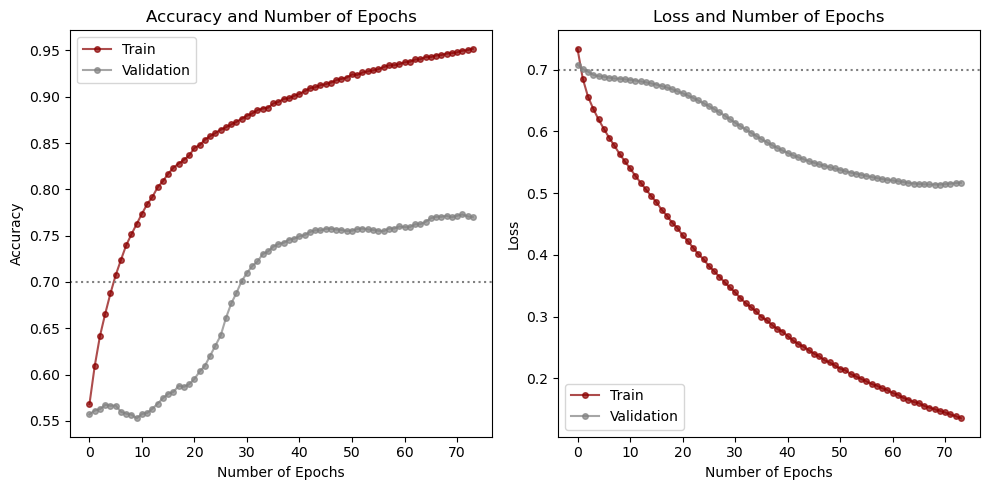

In [495]:
plot_res(train_acc, val_acc, train_loss, val_loss, ticks = 10)

In the plots above, we see how this model overfits less as the test accuracy is better and one could argue the discrepancy between test and train accuracy over epochs is smaller.

In [496]:
y_test_pred = model5.predict(x_test)
threshold = 0.5
y_test_class = np.where(y_test_pred > threshold, 1, 0).reshape(-1,)

2023-05-08 19:02:05.516410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]
2023-05-08 19:02:05.516895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [8268,32,32,3]
	 [[{{node Placeholder/_10}}]]


259/259 [==============================] - 3s 8ms/step


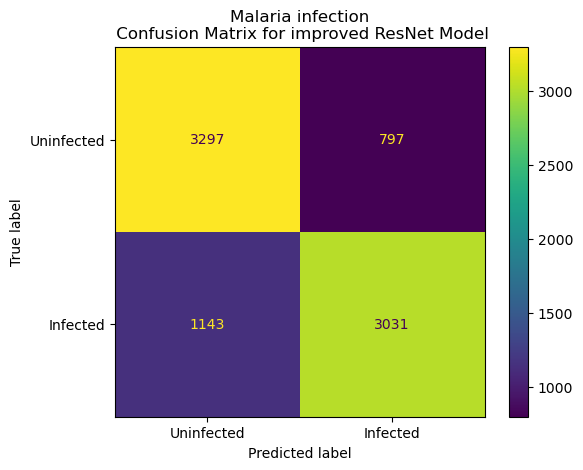

Accuracy: 76.54%
True Negative Rate: 80.53%
True Positive Rate: 72.62%
Precision: 79.18%
F1 Score: 75.76%


In [497]:
cm = conf_matrix(y_test, y_test_class, "Confusion Matrix for improved ResNet Model")

In the plot above, we can see that even though more uninfected cells are now correctly classified, we actually saw an increase in the number of infected cells misclassified as uninfected. 

# Overall Results

In [498]:
results_frame(results)

,Model,Train Accuracy,Validation Accuracy,Test Accuracy
0,Baseline CNN,0.59,0.59,0.59
1,Complex CNN,0.96,0.95,0.95
2,SOTA No Tune,0.86,0.80,0.80
3,Complex CNN Data Preprocessing,0.92,0.90,0.88
4,Complex CNN Data Augmentation,0.95,0.91,0.93
5,More Complex CNN Data Augmentation,0.94,0.91,0.94
6,ResNet Unfreezing Last 7 Layers,1.00,0.76,0.75
7,ResNet Unfreezing Last 19 Layers,0.95,0.77,0.77


In the table above, we can see that the model with the highest test accuracy was the second model we tested (the Complex CNN), however it was closely followed by the More Complex CNN with Data augmentation and the CNN with Data Augmentation. The Complex CNN had a larger number of infected cells misclassified as uninfected but a lower number of uninfected cells misclassified as infected, whereas the Complex CNN with data augmentation had a larger number of uninfected cells misclassified as infected but a lower number of infected cells misclassified as uninfected. Since we care about reducing false positives, we could argue that Model 4 (Complex CNN with Data Augmentation) outperforms the rest, but an equally valid statement would be to argue that Model 1 (Complex CNN) outperforms the others due to the higher accuracy. 

# Conclusions and Inferences

#### ResNet did worse than expected
Some possible reasons:
- Ma, L., Shuai, R., Ran, X. et al. Combining DC-GAN with ResNet for blood cell image classification. Med Biol Eng Comput 58, 1251–1264 (2020). https://doi.org/10.1007/s11517-020-02163-3
    - This paper was using ResNet to look at simple images of White Blood Cells, which is similar in task and apperance to ours. In looking only to classify white blood cell images,their accuracy was 86.1%, and using initialized parameters accuracy increased only to 88.7%. We find similar performance behavior in our task, which leads us to believe simple images like cell specamines are not fit for such heavy machinery, and is overfitting.
- We *trained* the last few layers of the network, rather than *freezing* the first few layers and training the remainder. This could be a resonable next approach.

#### Simple is better: ResNet not needed for simple images and task
In some cases, it may be unnecessary to use a complex model like ResNet for simple images and tasks. While ResNet is a powerful architecture that has achieved state-of-the-art results in image classification, object detection, and other computer vision tasks, it may not always be the most efficient or effective choice like in our case. Even when improved, the ResNet model could not achieve the accuracy of the CNN models.

#### Color and HSI are important features of microscopic samples when dye is involved
Color and HSI (Hue, Saturation, Intensity) are critical features of microscopic samples when dye is involved. In microscopy, dyes are often used to enhance the contrast and visibility of microscopic samples, especially those that are difficult to see under normal illumination. Therefore, improving those characteristics helps our model.

# Future Work

- Though ResNet did provide the best results, for which we suspect overfitting, it would be best to attempt fine-tuning with different learning rates to be sure.
- As mentioned, we could also attempt to freeze the first few layers and train the remainder, the complement of what we did in our actual attempt at improving ResNet's performance.
- Given Malaria is a parasitic disease with stages, clustering the infected cell images to uncover commonalities would allow us to better treat patients with urgency and or different doses of medication. A possible approach could be mixture models as they are a type of unsupervised machine learning algorithm that allows for the identification of underlying subpopulations or clusters.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=66f9e31f-2477-49d1-9a7c-ca696064c2d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>